# 2024 Aspect Based sentiment Project

# 1.Dataset Processing
This is a general data preprocessing step that includes removing punctuation, eliminating stop words, lemmatizing, converting to lowercase, and expanding contractions. Since each model requires a different way of integrating "aspect" information, there will be a subsection for data preparation specific to each model.

In [ ]:
# Install contractions package
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.9 MB/s eta 0:00:00


In [ ]:
# Import necessary toolkits
import json
import random
import warnings
from collections import Counter
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import contractions
from nltk.tokenize import word_tokenize
import spacy
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import ParameterGrid
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import tqdm
import math
from collections import defaultdict

# Suppress warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
random.seed(seed)
np.random.seed(seed)

In [ ]:
# Define dataset path
train_path = "/content/train.json"
val_path = "/content/val.json"
test_path = "/content/test.json"

In [ ]:
# Import JSON files as DataFrame
def importdata(path):
  with open(path, "r") as json_file:
    data = json.load(json_file)
    df = pd.DataFrame(data['data'], columns=data['columns'])
  return df

train_df = importdata(train_path)
val_df = importdata(val_path)
test_df = importdata(test_path)

# Separate the columns into lists
def listsplit(df):
  sentences = df['sentence'].tolist()
  aspects = df['aspect'].tolist()
  polarities = df['polarity'].tolist()
  return sentences, aspects, polarities

trainsentence, trainaspact, trainpolar = listsplit(train_df)
valsentence, valaspact, valpolar = listsplit(val_df)
testsentence, testaspact, testpolar = listsplit(test_df)

In [ ]:
# Load Spacy model for tokenization and lemmatization
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

# Function to handle text preprocessing using Spacy and contractions library
def pre_process(sent_list):
    output = []
    for sent in sent_list:
        sent = contractions.fix(sent)  # Expand contractions
        doc = nlp(sent)
         # Remove punctuation, stop words, lemanize, and change to lower case
        tokens = [token.lemma_.lower() for token in doc if not token.is_punct and not token.is_stop]
        output.append(tokens)
    return output

# Preprocessing the data using the function defined above
train_sentence_token_list = pre_process(trainsentence)
train_aspect_token_list = pre_process(trainaspact)
train_polarity_token_list = pre_process(trainpolar)

val_sentence_token_list = pre_process(valsentence)
val_aspect_token_list = pre_process(valaspact)
val_polarity_token_list = pre_process(valpolar)

test_sentence_token_list = pre_process(testsentence)
test_aspect_token_list = pre_process(testaspact)
test_polarity_token_list = pre_process(testpolar)

# Example pre-processed outputs
print('Original sentence: ', trainsentence[:1])
print('Tokenize sentence: ', train_sentence_token_list[:1])
print('')
print('Original aspect: ', trainaspact[:1])
print('Tokenize aspect: ', train_aspect_token_list[:1])
print('')
print('Original polarity: ', trainpolar[:1])
print('Tokenize polarity: ', train_polarity_token_list[:1])

Original sentence:  ["It might be the best sit down food I've had in the area, so if you are going to the upright citizen brigade, or the garden, it could be just the place for you."]
Tokenize sentence:  [['good', 'sit', 'food', 'area', 'go', 'upright', 'citizen', 'brigade', 'garden', 'place']]

Original aspect:  ['food']
Tokenize aspect:  [['food']]

Original polarity:  ['positive']
Tokenize polarity:  [['positive']]


# 2. Model Implementation

## Model 1: Dual Bi-LSTM Models for Sentence and Aspect
This model employs a Bi-LSTM architecture where both the sentence and aspect are provided as separate inputs to predict polarity.

### Data Preparation

In [ ]:
# Map word to index
def input2index(data, word2index):
    """
    Converts a list of sentences into a list of index lists based on a given word-to-index dictionary.
    """
    input_index_list = []
    for sent in data:
        sent_indices = []
        for w in sent:
            if w in word2index:
                sent_indices.append(word2index[w])
            else:
                sent_indices.append(word2index['<OOV>']) # Use the index for out-of-vocabulary words
        input_index_list.append(sent_indices)
    return input_index_list

# transfor word into tensor
class ABSADataset(Dataset):
  def __init__(self, sentences, aspects, labels):
    self.sentences = [torch.tensor(sentence, dtype=torch.long) for sentence in sentences]
    self.aspects = [torch.tensor(aspect, dtype=torch.long) for aspect in aspects]
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    """
    Returns the number of samples in the dataset.
    """
    return len(self.labels)

  def __getitem__(self, idx):
    """
    Retrieves the sample at the given index.

    Parameters:
    idx (int): The index of the sample to retrieve.

    Returns:
    tuple: A tuple containing the sentence tensor, aspect tensor, and label tensor for the given index.
    """
    return self.sentences[idx], self.aspects[idx], self.labels[idx]

# Corrected Collate Function
def collate_fn(batch):
  """
  Custom collate function to pad sequences in the batch to the same length for DataLoader.
  """
  sentences, aspects, labels = zip(*batch)
  sentences_padded = pad_sequence([torch.tensor(sentence, dtype=torch.long) for sentence in sentences], batch_first=True, padding_value=0)
  aspects_padded = pad_sequence([torch.tensor(aspect, dtype=torch.long) for aspect in aspects], batch_first=True, padding_value=0)
  labels = torch.stack([torch.tensor(label, dtype=torch.long) for label in labels])
  return sentences_padded, aspects_padded, labels

In [ ]:
# Encode polarity to index
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(trainpolar) # Encode training labels
val_labels = label_encoder.transform(valpolar) # Encode validation labels
test_labels = label_encoder.transform(testpolar) # Encode test labels

# move a vocab to index
word_to_ix = {'<PAD>': 0, # Padding token
             '<OOV>': 1} # Out Of Vocabulary token

# Build the vocabulary dictionary from training sentences and aspect tokens
for sentence in train_sentence_token_list + train_aspect_token_list:
  for word in sentence:
    if word not in word_to_ix:
      word_to_ix[word] = len(word_to_ix) # Assign a new index to the word

word_list = list(word_to_ix.keys()) # Create a list of words in the vocabulary

# Encode sentence and aspect using the word-to-index dictionary
encodetrainsen = input2index(train_sentence_token_list, word_to_ix) # Encode training sentences
encodetrainasp = input2index(train_aspect_token_list, word_to_ix) # Encode training aspects

encodevalsen = input2index(val_sentence_token_list, word_to_ix) # Encode validation sentences
encodevalass = input2index(val_aspect_token_list, word_to_ix) # Encode validation aspects

encodetestsen = input2index(test_sentence_token_list, word_to_ix) # Encode test sentences
encodetestass = input2index(test_aspect_token_list, word_to_ix) # Encode test aspects

# DataLoader with the corrected collate function
train_loader = DataLoader(ABSADataset(encodetrainsen, encodetrainasp, train_labels), batch_size=32, shuffle=True, collate_fn=collate_fn) # Create DataLoader for training data
val_loader = DataLoader(ABSADataset(encodevalsen, encodevalass, val_labels), batch_size=32, shuffle=False, collate_fn=collate_fn) # Create DataLoader for validation data
test_loader = DataLoader(ABSADataset(encodetestsen, encodetestass, test_labels), batch_size=32, shuffle=False, collate_fn=collate_fn) # Create DataLoader for test daat

### Model

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim, num_heads):
        """
        Create the Multi-Head Attention module.

        Args:
            hidden_dim (int): The dimension of the hidden states.
            num_heads (int): The number of attention heads.
        """
        super(MultiHeadAttention, self).__init__()
        assert hidden_dim % num_heads == 0
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads

        # project queries, keys, and values
        self.query_linear = nn.Linear(hidden_dim, hidden_dim)
        self.key_linear = nn.Linear(hidden_dim, hidden_dim)
        self.value_linear = nn.Linear(hidden_dim, hidden_dim)

        # combining the multi-head attention output
        self.fc_out = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, query, key, value, mask=None):
        """
        Compute the Multi-Head Attention.

        Args:
            query (torch.Tensor): The query tensor.
            key (torch.Tensor): The key tensor.
            value (torch.Tensor): The value tensor.
        """
        batch_size = query.shape[0]

        # Project the queries, keys, and values
        query = self.query_linear(query).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        key = self.key_linear(key).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        value = self.value_linear(value).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        # Compute the attention scores
        energy = torch.einsum("bnqd,bnkd->bnqk", [query, key])

        # Apply the attention mask
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # Compute the attention weights
        attention = torch.softmax(energy / (self.head_dim ** 0.5), dim=-1)

        # Compute the weighted sum
        x = torch.einsum("bnqk,bnvd->bnqd", [attention, value]).reshape(batch_size, -1, self.hidden_dim)

        # Apply the output linear layer
        out = self.fc_out(x)
        return out, attention

# Define Aspect Extraction Module
class AspectExtractionModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
    super(AspectExtractionModel, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0) # Embedding layer that converts word indices into dense vectors of size (embedding_dim)
    self.hidden_dim = hidden_dim
    self.bilstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True) # Bidirectional LSTM layer
    self.fc = nn.Linear(hidden_dim * 2, output_dim) # A fully connected (linear) layer that maps the LSTM's hidden states to the output dimension (input size to this layer is twice the hidden dimension because the LSTM is bidirectional)

  def forward(self, aspect):
    embedded = self.embedding(aspect)
    lstm_out, _ = self.bilstm(embedded)
    aspect_output = self.fc(lstm_out[:, -1, :]) # Take the last hidden state
    return aspect_output


class SentenceExtractionModelWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_heads):
        """
        Create the SentenceExtractionModelWithAttention.

        Args:
            vocab_size: The size of the vocabulary.
            embedding_dim: The dimension of the word embeddings.
            hidden_dim: The dimension of the hidden states.
            output_dim: The dimension of the output.
        """
        super(SentenceExtractionModelWithAttention, self).__init__()

        # convert input tokens to embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        self.hidden_dim = hidden_dim
        self.num_heads = num_heads

        # BiLSTM layer
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim // 2, batch_first=True, bidirectional=True)

        # Multi-Head Attention module layer
        self.multiattentionhead = MultiHeadAttention(hidden_dim, num_heads)

        # Fully connected layer to project output dimension
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, sentence):
        """
        Calculate the sentence output and attention weights.

        Args:
            sentence: The input sentence tensor.

        Returns:
            sentence_output: The sentence output tensor.
            attention_weights: The attention weights tensor.
        """
        # Embed the input sentence
        embedded = self.embedding(sentence)

        # Pass the embedded sequence through BiLSTM
        lstm_out, _ = self.bilstm(embedded)

        # Apply multi-head attention
        attn_out, attention_weights = self.multiattentionhead(lstm_out, lstm_out, lstm_out)

        # Project the output dimension
        sentence_output = self.fc(attn_out[:, -1, :])

        return sentence_output, attention_weights

class CombinedModel(nn.Module):
    def __init__(self, aspect_model, sentence_model, aspect_output_dim, polarity_output_dim):
        """
        Initialize the CombinedModel.

        Args:
            aspect_model (nn.Module): The pre-trained aspect model.
            sentence_model (nn.Module): The pre-trained sentence model.
            aspect_output_dim (int): The output dimension of the aspect model.
            polarity_output_dim (int): The output dimension for polarity prediction.
        """
        super(CombinedModel, self).__init__()

        # Store the pre-trained aspect and sentence models
        self.aspect_model = aspect_model
        self.sentence_model = sentence_model

        # Fully connected layer to project aspect output
        self.fc1 = nn.Linear(aspect_output_dim, polarity_output_dim)

        # Fully connected layer to combine aspect and sentence outputs
        self.fc2 = nn.Linear(polarity_output_dim * 2, polarity_output_dim)

    def forward(self, sentence, aspect):
        """
        Calculate the polarity probabilities and attention weights.

        Args:
            sentence: The input sentence tensor.
            aspect: The input aspect tensor.

        Returns:
            probs: The polarity probabilities tensor.
            attention_weights: The attention weights tensor.
        """
        # Pass the sentence through the sentence model
        sentence_output, attention_weights = self.sentence_model(sentence)

        # Pass the aspect through the aspect model
        aspect_output = self.aspect_model(aspect)

        # Project the aspect output to the polarity output dimension
        aspect_output = self.fc1(aspect_output)

        # Concatenate the projected aspect output and sentence output
        combined_output = torch.cat((aspect_output, sentence_output), dim=1)

        # Pass the combined output through the final fully connected layer
        combined_output = self.fc2(combined_output)

        # Apply softmax to get polarity probabilities
        probs = F.softmax(combined_output, dim=1)

        return probs, attention_weights


In [ ]:
# create the function to train the model
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for i, (src, aspects, trg) in enumerate(iterator):
        # Move the input and target tensors to the specified device
        src, aspects, trg = src.to(device), aspects.to(device), trg.to(device)
        optimizer.zero_grad()
        output, _ = model(src, aspects)
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() # Accumulate the loss
    return epoch_loss / len(iterator) # Return the average loss for the epoch

# create the function to evaluate the
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    correct = 0
    total = 0
    attention_weights_list = []
    predictions = []
    ground_truths = []
    with torch.no_grad():
        for i, (src, aspects, trg) in enumerate(iterator):
            src, aspects, trg = src.to(device), aspects.to(device), trg.to(device)
            output, attention_weights = model(src, aspects)
            loss = criterion(output, trg)
            epoch_loss += loss.item()

            _, predicted = torch.max(output, 1) # Get the predicted labels
            total += trg.size(0) # Accumulate the total number of samples
            correct += (predicted == trg).sum().item() # Accumulate the number of correct predictions
            attention_weights_list.append(attention_weights.cpu().numpy()) # Store the attention weights

            predictions.extend(predicted.cpu().numpy()) # Store the predictions
            ground_truths.extend(trg.cpu().numpy()) # Store the ground truths

    accuracy = correct / total
    return epoch_loss / len(iterator), accuracy, attention_weights_list, predictions, ground_truths # Return average loss, accuracy, and attention weights

# Plot a bar chart of attention weights for a given sentence and aspect.
def attentionplot(attention, sentence, aspect, predicted_polarity, groundtruth):
    attention = attention[:len(sentence)] # Truncate attention weights to the length of the sentence
    fig, ax = plt.subplots(figsize=(15, 5))
    bar_width = 0.4
    indices = np.arange(len(sentence))

    # Plotting the bar chart
    ax.bar(indices, attention, bar_width, alpha=0.7, color='b', label='Attention Weight')

    # Adding labels
    ax.set_ylabel('Attention Weight', fontsize=12)
    ax.set_title(f'Aspect: {aspect} | Predicted: {predicted_polarity} | True: {groundtruth}', fontsize=14)
    ax.set_xticks(indices)
    ax.set_xticklabels(sentence, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show() # Return average loss, accuracy, and attention weights

In [ ]:
# Define the device for computations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the hyperparameters grid for the grid search
hyperparameters_grid = {
    'criterion': [nn.CrossEntropyLoss()],
    'optimizer': [optim.Adam],
    'lr': [0.01, 0.001],
    'embedding_dim': [50, 100],
    'hidden_dim': [64, 128]
}

# Set up the parameter
epochs = 50
vocab_size = len(word_to_ix)
num_heads = 8

# Dictionaries to store results
bestaccuracy_perparams_m1 = {}
trainloss_m1 = {}
valloss_perparams_m1 = {}
accuracy_perparams_m1 = {}

# Loop over each combination of parameters
for params in ParameterGrid(hyperparameters_grid):
    print(f"Starting training with parameters: {params}")

    bestaccuracy_perparams_m1[str(params)] = -1
    trainloss_m1[tuple(params.items())] = []
    valloss_perparams_m1[tuple(params.items())] = []
    accuracy_perparams_m1[tuple(params.items())] = []

    # Set the random seed for reproducibility
    seed = 42
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)

    # Initialize the models
    aspect_output_dim = len(set(trainaspact + valaspact + testaspact))
    polarity_output_dim = len(set(trainpolar + valpolar + testpolar))
    aspect_model = AspectExtractionModel(vocab_size, params['embedding_dim'], params['hidden_dim'], aspect_output_dim).to(device)
    sentence_model = SentenceExtractionModelWithAttention(vocab_size, params['embedding_dim'], params['hidden_dim'], polarity_output_dim, num_heads).to(device)
    model = CombinedModel(aspect_model, sentence_model, aspect_output_dim, polarity_output_dim).to(device)

    # Initialize the optimizer
    optimizer = params['optimizer'](model.parameters(), lr=params['lr'])

    # Define the loss function
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(epochs):
        train_loss = train(model, train_loader, optimizer, criterion)
        val_loss, val_accuracy, _, _, _ = evaluate(model, val_loader, criterion)

        trainloss_m1[tuple(params.items())].append(train_loss)
        valloss_perparams_m1[tuple(params.items())].append(val_loss)
        accuracy_perparams_m1[tuple(params.items())].append(val_accuracy)

        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs} - Training loss: {train_loss:.4f} - Validation loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}')

        # Save the best model based on validation accuracy
        if val_accuracy > bestaccuracy_perparams_m1[str(params)]:
            bestaccuracy_perparams_m1[str(params)] = round(val_accuracy, 4)
            model_name = f"best_val_model_{params}.pt"
            torch.save(model, model_name)

    print(f'Completed training with parameters: {params}. Best Accuracy: {bestaccuracy_perparams_m1[str(params)]:.4f}')
    print("=" * 50)

# Print the best results from the grid search
print("Grid search complete. Best results:")
for params, acc in bestaccuracy_perparams_m1.items():
    print(f"Params: {params} - Best Validation Accuracy: {acc:.4f}")


Starting training with parameters: {'criterion': CrossEntropyLoss(), 'embedding_dim': 50, 'hidden_dim': 64, 'lr': 0.01, 'optimizer': <class 'torch.optim.adam.Adam'>}
Epoch 0/50 - Training loss: 0.9806 - Validation loss: 0.9625 - Validation Accuracy: 0.5890
Epoch 10/50 - Training loss: 1.1173 - Validation loss: 1.1139 - Validation Accuracy: 0.4369
Epoch 20/50 - Training loss: 1.1175 - Validation loss: 1.1139 - Validation Accuracy: 0.4369
Epoch 30/50 - Training loss: 1.1172 - Validation loss: 1.1139 - Validation Accuracy: 0.4369
Epoch 40/50 - Training loss: 1.1177 - Validation loss: 1.1139 - Validation Accuracy: 0.4369
Completed training with parameters: {'criterion': CrossEntropyLoss(), 'embedding_dim': 50, 'hidden_dim': 64, 'lr': 0.01, 'optimizer': <class 'torch.optim.adam.Adam'>}. Best Accuracy: 0.5890
Starting training with parameters: {'criterion': CrossEntropyLoss(), 'embedding_dim': 50, 'hidden_dim': 64, 'lr': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}
Epoch 0/50 - Train

In [ ]:
# Find the best hyperparameters based on the highest accuracy
best_accuracy = -1
for params, accuracy in bestaccuracy_perparams_m1.items():
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        bestmodel1 = params

# Print the best hyperparameters and accuracy if found
if bestmodel1 is not None:
    print("Best Hyperparameters for Model 3:", bestmodel1)
    print("Best Accuracy achieved from Model 3:", best_accuracy)
else:
    print("No valid accuracy values found.")

Best Hyperparameters for Model 3: {'embedding_dim': 100, 'hidden_dim': 64, 'lr': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}
Best Accuracy achieved from Model 3: 0.6678


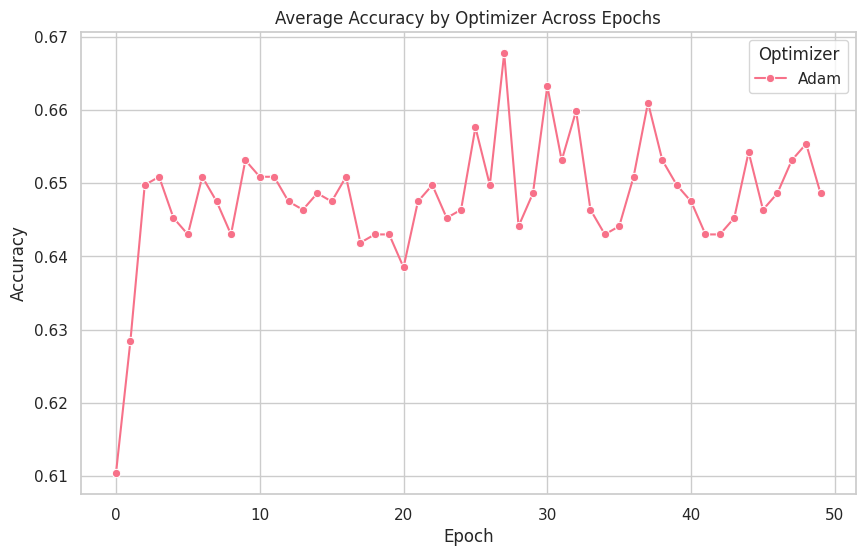

In [ ]:
# Visualization of accuracy across epochs for different optimizers
sns.set(style="whitegrid")
palette = sns.color_palette("husl", 3) # sET THE COLOR PALETTE
data = []

# Prepare the data for plotting
for params, accuracies in accuracy_perparams_m1.items():
    for epoch, accuracy in enumerate(accuracies):
        data.append({
            'Epoch': epoch,
            'Accuracy': accuracy,
            'Optimizer': params[-1][1].__name__  # Extract optimizer name
        })

df = pd.DataFrame(data)

# Create the plot
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x="Epoch", y="Accuracy", hue="Optimizer", data=df, palette=palette, marker="o")
ax.set(title='Average Accuracy by Optimizer Across Epochs', xlabel='Epoch', ylabel='Accuracy')
plt.legend(title='Optimizer')
plt.show()

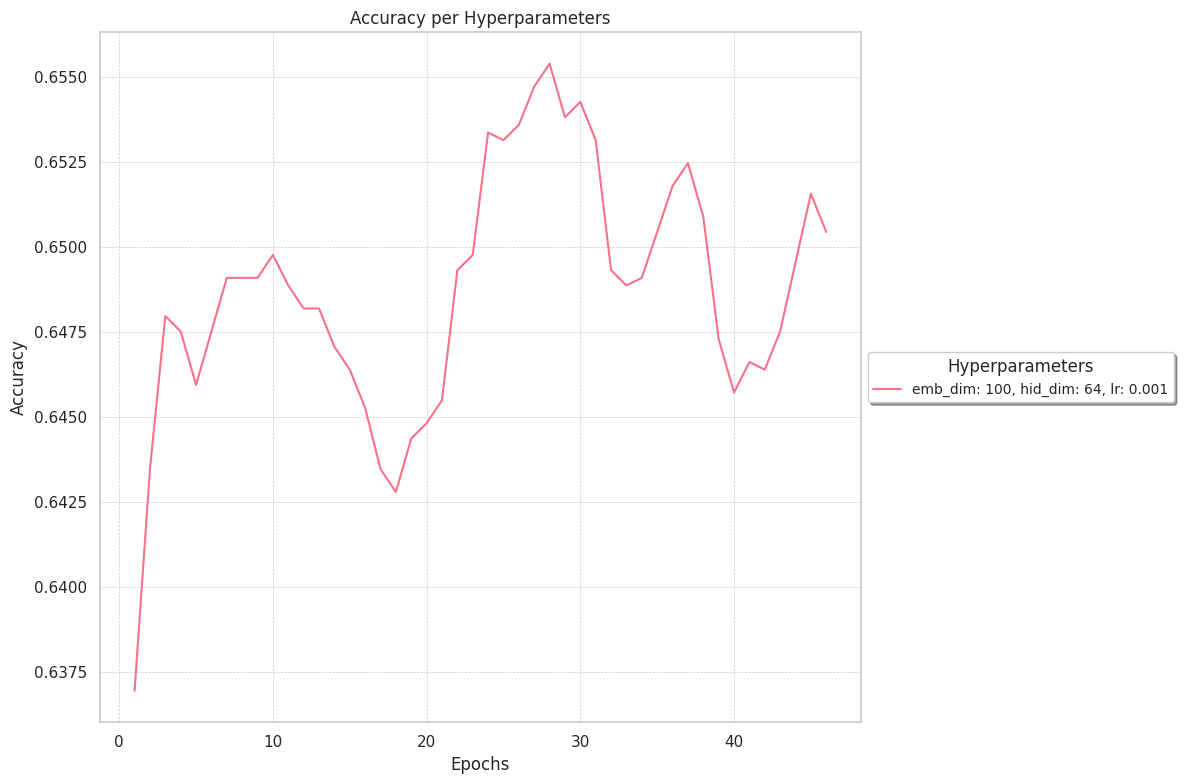

In [ ]:
def averages(data, window_size=5):
    """
    Compute the moving average of the given data using a specified window size.
    """
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Compute the smoothed accuracies
accurcttper = defaultdict(list)

# Compute the smoothed accuracies for each set of hyperparameters
for key, values in accuracy_perparams_m1.items():
    accurcttper[key] = averages(values, window_size=5)

# Plot tuning results
plt.figure(figsize=(12, 8))
palette = sns.color_palette("husl", len(accurcttper))

# plot the accuracy for each set of hyperparameters
for i, (key, values) in enumerate(accurcttper.items()):
    plt.plot(np.arange(1, len(values) + 1), values, label=f"emb_dim: {key[0][1]}, hid_dim: {key[1][1]}, lr: {key[2][1]}", color=palette[i])

# Add labels, title, grid, and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Hyperparameters')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, ncol=1, fontsize='small', title='Hyperparameters')
plt.tight_layout()
plt.show()


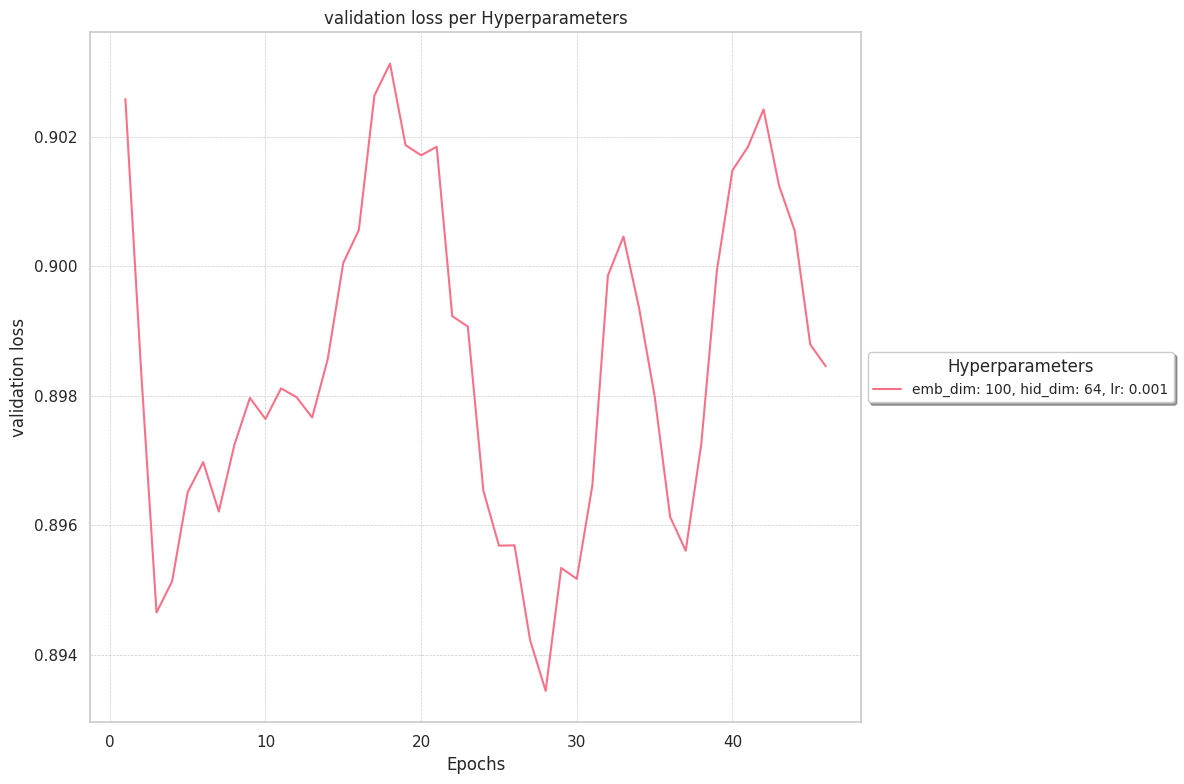

In [ ]:
def averages(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Compute the smoothed accuracies
accurcttper = defaultdict(list)

# Compute the smoothed accuracies
for key, values in valloss_perparams_m1.items():
    accurcttper[key] = averages(values, window_size=5)

# Plot tuning results
plt.figure(figsize=(12, 8))
palette = sns.color_palette("husl", len(accurcttper))

# plot the chart
for i, (key, values) in enumerate(accurcttper.items()):
    plt.plot(np.arange(1, len(values) + 1), values, label=f"emb_dim: {key[0][1]}, hid_dim: {key[1][1]}, lr: {key[2][1]}", color=palette[i])

# Add labels, title, grid, and legend
plt.xlabel('Epochs')
plt.ylabel('validation loss')
plt.title('validation loss per Hyperparameters')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, ncol=1, fontsize='small', title='Hyperparameters')
plt.tight_layout()
plt.show()


In [ ]:
data = []
for Prms in valloss_perparams_m1:

    # Extract parameter values from the tuple
    params_dict = {param[0]: param[1] for param in Prms}

    # Extract optimizer name from the dictionary
    optimizer_name = params_dict['optimizer'].__name__

    # Calculate average or last values for accuracy, training loss, and validation loss
    avg_accuracy = sum(accuracy_perparams_m1[Prms]) / len(accuracy_perparams_m1[Prms])
    avg_train_loss = sum(trainloss_m1[Prms]) / len(trainloss_m1[Prms])
    avg_val_loss = sum(valloss_perparams_m1[Prms]) / len(valloss_perparams_m1[Prms])

    # Append row to data list
    data.append({
        'Optimizer': optimizer_name,
        'Learning Rate': params_dict['lr'],
        'Embedding Dim': params_dict['embedding_dim'],
        'Hidden Dim': params_dict['hidden_dim'],
        'Average Accuracy': avg_accuracy,
        'Average Training Loss': avg_train_loss,
        'Average Validation Loss': avg_val_loss
    })


ablation = pd.DataFrame(data)

# Sort the DataFrame by specific columns
ablation.sort_values(by=['Optimizer', 'Learning Rate', 'Embedding Dim', 'Hidden Dim'], inplace=True)
ablation.reset_index(drop=True, inplace=True)

# print(tabulate(ablation, headers='keys', tablefmt='pretty'))
ablation

,Optimizer,Learning Rate,Embedding Dim,Hidden Dim,Average Accuracy,Average Training Loss,Average Validation Loss
0,Adam,0.001,100,64,0.647973,0.763426,0.898884


In [ ]:
# Test on test dataset
model1result = max(bestaccuracy_perparams_m1, key=bestaccuracy_perparams_m1.get)
bestmodele = torch.load(f"best_val_model_{model1result}.pt")
criterion = nn.CrossEntropyLoss()

test_loss, test_accuracy, attention_weights_list, all_preds, all_labels = evaluate(bestmodele, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.2f}')

print("\nClassification Report:\n")
labels = ["negative", "neutral", "positive"]
print(classification_report(all_labels, all_preds, target_names=labels))


Test Loss: 0.903, Test Accuracy: 0.64

Classification Report:

              precision    recall  f1-score   support

    negative       0.59      0.62      0.61       263
     neutral       0.70      0.77      0.73       393
    positive       0.55      0.44      0.49       245

    accuracy                           0.64       901
   macro avg       0.62      0.61      0.61       901
weighted avg       0.63      0.64      0.63       901



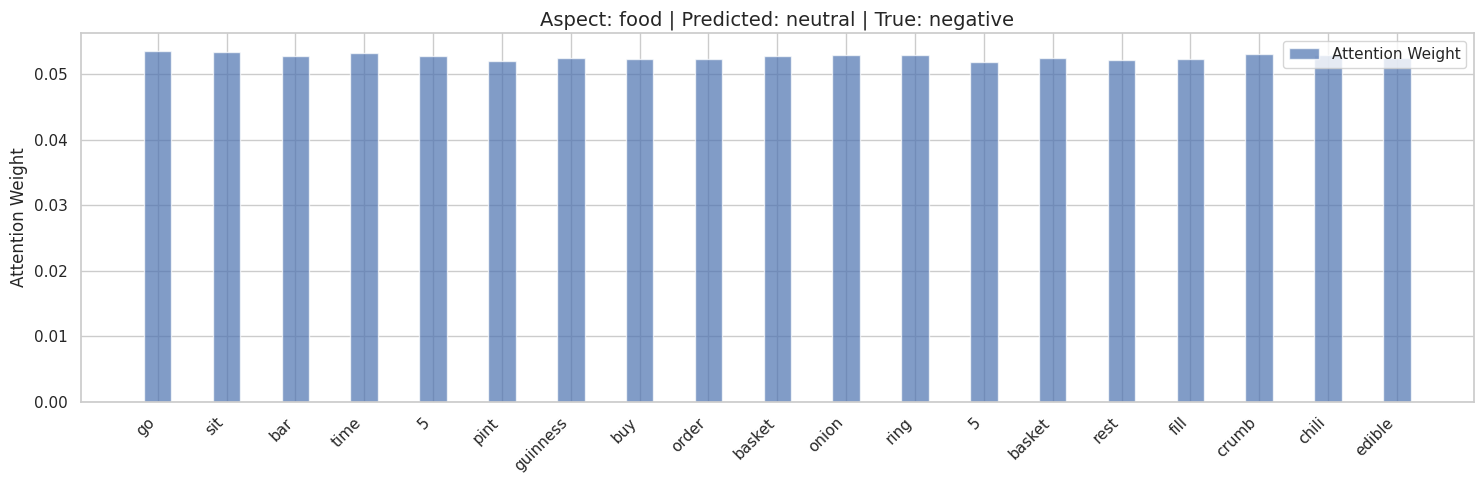

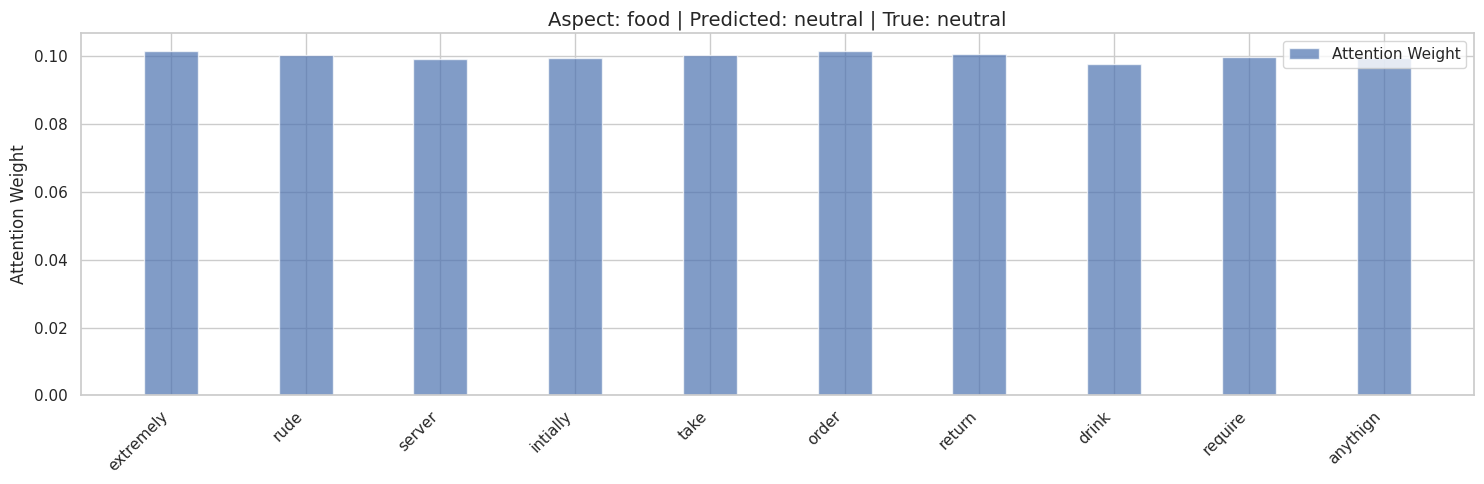

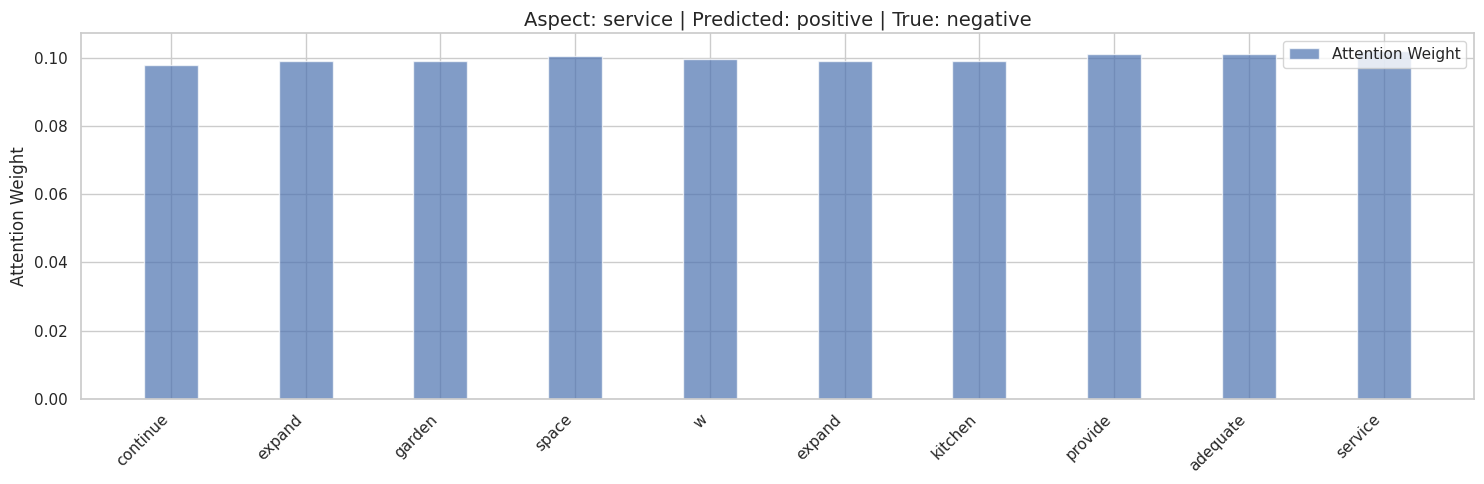

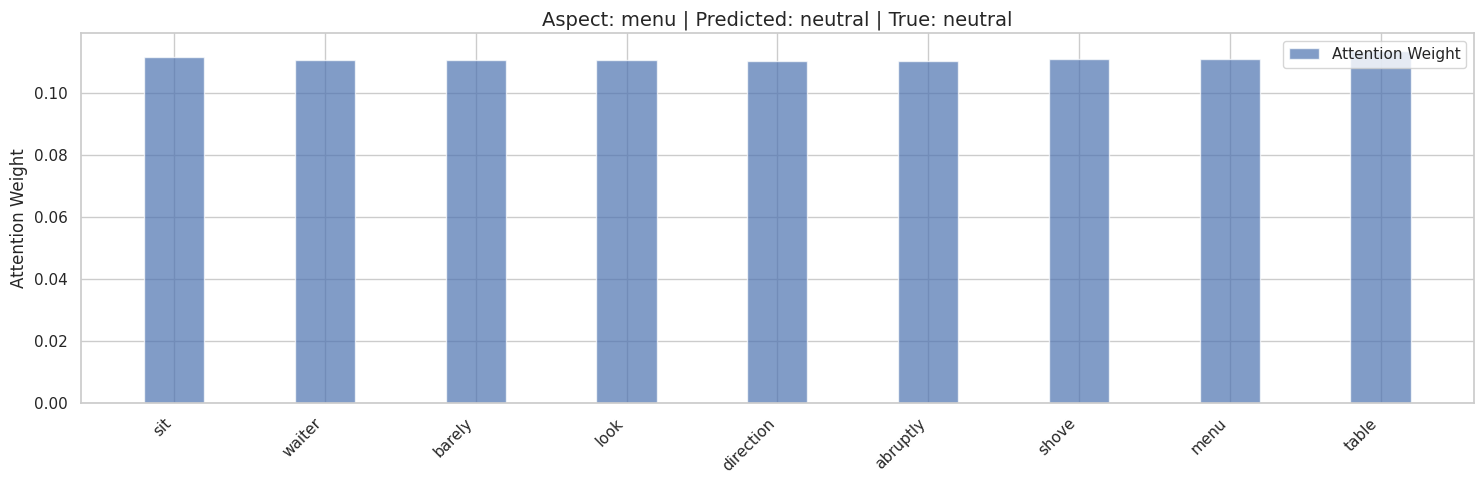

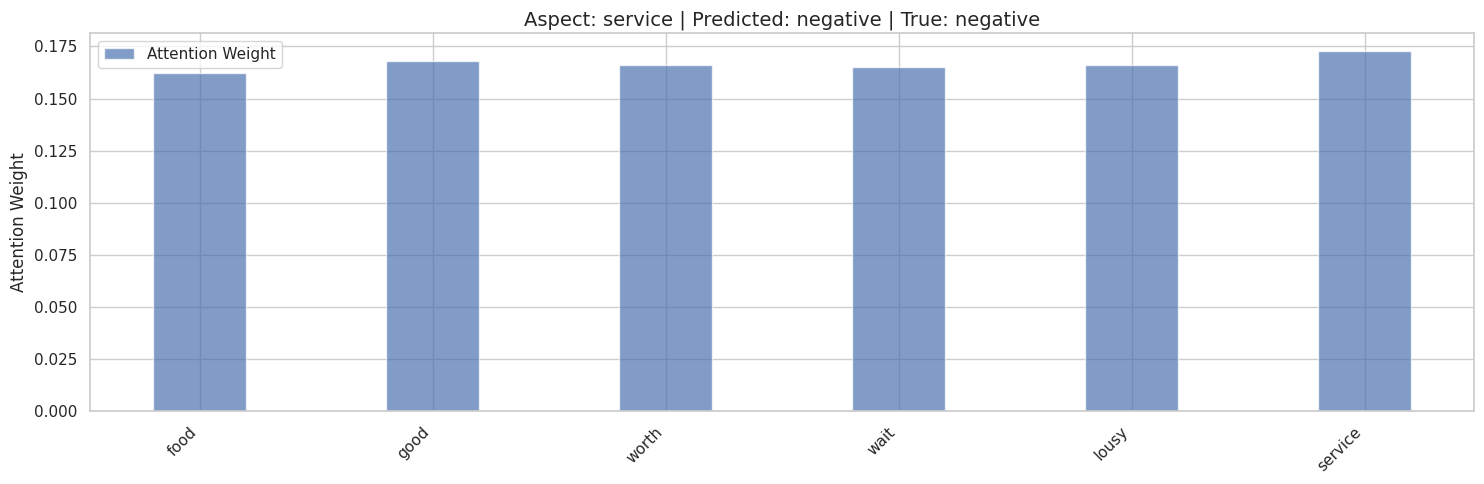

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



# Define the test sentences
testingsentence = [
    {
        "sentence": "We went again and sat at the bar this time, I had 5 pints of guinness and not one buy-back, I ordered a basket of onion rings and there were about 5 in the basket, the rest was filled with crumbs, the chili was not even edible.",
        "aspects": ["food"],
        "polarities": ["negative"]
    },
    {
        "sentence": "Extremely RUDE servers who intially took our order and never returned with drinks or to see if we required anythign else.",
        "aspects": ["food"],
        "polarities": ["neutral"]
    },
    {
        "sentence": "they continue to expand their garden space, w/out expanding their kitchen and cannot provide even adequate service.",
        "aspects": ["service"],
        "polarities": ["negative"]
    },
    {
        "sentence": "When we sat down, the waiter barely looked in our direction and abruptly shoved our menus on the table.",
        "aspects": ["menu"],
        "polarities": ["neutral"]
    },
    {
        "sentence": "The food was good, but it's not worth the wait--or the lousy service.",
        "aspects": ["service"],
        "polarities": ["negative"]
    }
]

results = []

# Perform prediction for each sentence
for example in testingsentence:
    sentence = example["sentence"]
    aspects = example["aspects"]
    groundtruth = example["polarities"]

    # Preprocess the sentence
    tokens = pre_process([sentence])[0]
    inputidx = [word_to_ix.get(word, word_to_ix['<OOV>']) for word in tokens]
    inputsentence = torch.tensor(inputidx, dtype=torch.long).unsqueeze(0).to(device)

    # Set the model to evaluation mode
    model.eval()

    for i, aspect in enumerate(aspects):
        aspectidx = [word_to_ix.get(aspect, word_to_ix['<OOV>'])]
        inputaspect = torch.tensor(aspectidx, dtype=torch.long).unsqueeze(0).to(device)

        # Save the attention weights
        with torch.no_grad():
            output, attention = model(inputsentence, inputaspect)
            attention_weights = attention[0][0].mean(dim=0).cpu().numpy()

        # Get the predicted result
        predicted_polarity = torch.argmax(output, dim=1).item()

        # Record the result
        results.append({
            "Sentence": sentence,
            "Aspect": aspect,
            "Predicted Polarity": label_encoder.inverse_transform([predicted_polarity])[0],
            "True Polarity": groundtruth[i]
        })

        # Plot the attention bar chart
        attentionplot(attention_weights, tokens, aspect, label_encoder.inverse_transform([predicted_polarity])[0], groundtruth[i])




In [ ]:
# Convert the results to a DataFrame and print
df_results = pd.DataFrame(results, columns=["Sentence", "Aspect", "Predicted Polarity", "True Polarity"])
print(df_results)

                                            Sentence   Aspect  \
0  We went again and sat at the bar this time, I ...     food   
1  Extremely RUDE servers who intially took our o...     food   
2  they continue to expand their garden space, w/...  service   
3  When we sat down, the waiter barely looked in ...     menu   
4  The food was good, but it's not worth the wait...  service   

  Predicted Polarity True Polarity  
0            neutral      negative  
1            neutral       neutral  
2           positive      negative  
3            neutral       neutral  
4           negative      negative  


## Model 2: Seq2Seq Model using both sentence and aspect
This model uses an encoder-decoder architecture, integrating both the sentence and its associated aspect as input to predict polarity.

### Data Preparation

In [ ]:
# Add <ASP> between sentence and aspect for encoder input
# Ex. ['good', 'sit', 'food', 'area', 'go', 'upright', 'citizen', 'brigade', 'garden', 'place', '<ASP>', 'food']
def add_asp(sentence_token_list, aspect_token_list):
  output = []
  for sublist1, sublist2 in zip(sentence_token_list, aspect_token_list):
    sent = sublist1 + ['<ASP>'] + sublist2
    output.append(sent)
  return output

# Add <ASP> to training set
train_input_token_list = add_asp(train_sentence_token_list, train_aspect_token_list)

# Add <ASP> to validation set
val_input_token_list = add_asp(val_sentence_token_list, val_aspect_token_list)

# Add <ASP> to test set
test_input_token_list = add_asp(test_sentence_token_list, test_aspect_token_list)

print("Sample tokenize sentence after add <ASP>:\n", train_input_token_list[0])

Sample tokenize sentence after add <ASP>:
 ['good', 'sit', 'food', 'area', 'go', 'upright', 'citizen', 'brigade', 'garden', 'place', '<ASP>', 'food']


In [ ]:
# Adding special tokens for generation: <BOS> indicates beginning of sentence, <EOS> means end of sentence
def add_special_token(token_list):
  s = [["<BOS>"] + s for s in token_list]
  return [s + ["<EOS>"] for s in s]

# Add special tokens to training set
train_src_tokens = add_special_token(train_input_token_list)
train_trg_tokens = add_special_token(train_polarity_token_list)

# Add special tokens to validation set
val_src_tokens = add_special_token(val_input_token_list)
val_trg_tokens = add_special_token(val_polarity_token_list)

# Add special tokens to test set
test_src_tokens = add_special_token(test_input_token_list)
test_trg_tokens = add_special_token(test_polarity_token_list)

assert len(train_src_tokens)==len(train_trg_tokens)
print("Sample tokenize sentence after add <BOS> and <EOS>:")
print(train_src_tokens[0])
print(train_trg_tokens[0])

Sample tokenize sentence after add <BOS> and <EOS>:
['<BOS>', 'good', 'sit', 'food', 'area', 'go', 'upright', 'citizen', 'brigade', 'garden', 'place', '<ASP>', 'food', '<EOS>']
['<BOS>', 'positive', '<EOS>']


In [ ]:
# Here we simply use the maximum sentence length
MAX_LENGTH = max(len(sublist) for sublist in train_src_tokens)
print("Maximum length:", MAX_LENGTH)

Maximum length: 45


In [ ]:
# Set up a vocab to index dictionary for encoder
encoder_word_to_ix = {'<PAD>': 0, # Padding token
             '<OOV>': 1, # Out Of Vocabulary token
             '<BOS>': 2, # Beginning of the sentence
             '<EOS>': 3, # End of the sentence
             '<ASP>': 4} # Aspect of the sentence

for sentence in train_src_tokens:
    for word in sentence:
        if word not in encoder_word_to_ix:
            encoder_word_to_ix[word] = len(encoder_word_to_ix)

encoder_word_list = list(encoder_word_to_ix.keys())

# First 15 encoder vocabularies
print('First 15  encoder vocabularies:', encoder_word_list[:15])

First 15  encoder vocabularies: ['<PAD>', '<OOV>', '<BOS>', '<EOS>', '<ASP>', 'good', 'sit', 'food', 'area', 'go', 'upright', 'citizen', 'brigade', 'garden', 'place']


In [ ]:
# Set up a vocab to index dictionary for decoder
decoder_word_to_ix = {
    '<PAD>': 0, # Padding
    '<BOS>': 1, # Beginning of the sentence
    '<EOS>': 2, # End of the sentence
}

for sentence in train_trg_tokens:
    for word in sentence:
        if word not in decoder_word_to_ix:
            decoder_word_to_ix[word] = len(decoder_word_to_ix)

decoder_word_list = list(decoder_word_to_ix.keys())

# Decoder vocabularies
print('Decoder vocabularies:', decoder_word_list)

Decoder vocabularies: ['<PAD>', '<BOS>', '<EOS>', 'positive', 'neutral', 'negative']


In [ ]:
# Pad all sentences into the max length
train_src_tokens = [sublist + ['<PAD>'] * (MAX_LENGTH - len(sublist)) for sublist in train_src_tokens]
train_trg_tokens = [sublist + ['<PAD>'] * (MAX_LENGTH - len(sublist)) for sublist in train_trg_tokens]

val_src_tokens = [sublist + ['<PAD>'] * (MAX_LENGTH - len(sublist)) for sublist in val_src_tokens]
val_trg_tokens = [sublist + ['<PAD>'] * (MAX_LENGTH - len(sublist)) for sublist in val_trg_tokens]

test_src_tokens = [sublist + ['<PAD>'] * (MAX_LENGTH - len(sublist)) for sublist in test_src_tokens]
test_trg_tokens = [sublist + ['<PAD>'] * (MAX_LENGTH - len(sublist)) for sublist in test_trg_tokens]

assert len(train_src_tokens[0]) == len(train_trg_tokens[0])
print('Sample tokenize sentence after padding:')
print(train_src_tokens[0])
print(train_trg_tokens[0])

Sample tokenize sentence after padding:
['<BOS>', 'good', 'sit', 'food', 'area', 'go', 'upright', 'citizen', 'brigade', 'garden', 'place', '<ASP>', 'food', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<BOS>', 'positive', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


In [ ]:
class Seq2SeqDataset(Dataset):
  def __init__(self, src_data, trg_data, encoder_word_to_ix, decoder_word_to_ix):
    self.src_data = self.input2index(src_data, encoder_word_to_ix)
    self.trg_data = self.input2index(trg_data, decoder_word_to_ix)

  def __len__(self):
      return len(self.src_data)

  def __getitem__(self, idx):
      src_seq = torch.tensor(self.src_data[idx])
      trg_seq = torch.tensor(self.trg_data[idx])
      return src_seq, trg_seq

  def input2index(self, data, word2index):
    input_index_list = []
    for sent in data:
        sent_indices = []
        for w in sent:
            if w in word2index:
                sent_indices.append(word2index[w])
            else:
                # If word is not in vocabulary, use special OOV token index
                sent_indices.append(word2index['<OOV>'])
        input_index_list.append(sent_indices)
    return input_index_list

### Model

In [ ]:
# Seq2Seq Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, n_layers, dropout, pad_id):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_id) # Encoder embedding layer to convert word indices to word embeddings
        self.RNN = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout) # Encoder recurrent layer, LSTM layer for processing the embedded input sequence
        self.dropout = nn.Dropout(dropout) # Dropout layer for regularization

    def forward(self, input):
        embedded = self.dropout(self.embedding(input)) # Apply dropout to the embeddings
        outputs, (hidden, cell) = self.RNN(embedded) # Pass the embedded input through the LSTM
        return hidden, cell  # Return the final hidden and cell states

# Seq2Seq Decoder
class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers, dropout, pad_id):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, embedding_dim, padding_idx=pad_id) # Decoder embedding layer to convert word indices to word embeddings
        self.RNN = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout) # Decoder recurrent layer, LSTM layer for processing the embedded input sequence
        self.fc = nn.Linear(hidden_dim, output_dim) # Linear layer to map the LSTM output to the target vocabulary size
        self.dropout = nn.Dropout(dropout)  # Dropout layer for regularization

    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0) # Add a time dimension to the input tensor (from [batch_size] to [1, batch_size])
        embedded = self.dropout(self.embedding(input)) # Apply dropout to the embeddings
        output, (hidden, cell) = self.RNN(embedded, (hidden, cell)) # Pass the embedded input through the LSTM
        prediction = self.fc(output.squeeze(0)) # Remove the time dimension and apply the linear layer to get predictions
        return prediction, hidden, cell # Return the predictions and the new hidden and cell states

# Seq2Seq Model
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, device):
      super().__init__()
      self.encoder = encoder
      self.decoder = decoder
      self.device = device

  def forward(self, src, trg, teacher_forcing_ratio):
    """
    Forward pass for the sequence-to-sequence model with teacher forcing.

    Parameters:
    src (Tensor): Source sequence tensor (input to the encoder).
    trg (Tensor): Target sequence tensor (input to the decoder for teacher forcing and for computing loss).
    teacher_forcing_ratio (float): Probability of using teacher forcing (i.e., using the actual next token as the next input to the decoder).

    Returns:
    Tensor: Output predictions from the decoder for each time step in the target sequence.
    """

    batch_size = trg.shape[1]
    trg_length = trg.shape[0]
    trg_vocab_size = self.decoder.output_dim

    # Tensor to store decoder outputs at each time step
    outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)

    # Pass the source sequence through the encoder to get the initial hidden and cell states
    hidden, cell = self.encoder(src)

    # The first input to the decoder is the <BOS> token (beginning of sequence)
    input = trg[0, :]

    # Iterate over the target sequence length
    for t in range(1, trg_length):
        # Pass the current input, hidden, and cell states to the decoder
        output, hidden, cell = self.decoder(input, hidden, cell)

        # Store the current output (predicted token probabilities) in the outputs tensor
        outputs[t] = output

        # Decide whether to use teacher forcing for the next input
        teacher_force = random.random() < teacher_forcing_ratio

        # Get the highest predicted token from the decoder's output
        predicted = output.argmax(1)

        # If using teacher forcing, use the actual next token from the target sequence as the next input
        # Otherwise, use the predicted token
        input = trg[t] if teacher_force else predicted

    return outputs

In [ ]:
def modeltraining(model, data_loader, optimizer, criterion, lr, teacher_forcing_ratio, device):
  epoch_loss = 0
  correct_predictions = 0
  total_predictions = 0

  # Loss function and optimizer
  criterion = nn.CrossEntropyLoss(ignore_index=pad_index)
  optimizer = optimizer(model.parameters(), lr=lr)

  # Set model in training mode
  model.train()

  for i, (batch_input, batch_polarity) in enumerate(data_loader):
    input = batch_input.to(device)
    polarity = batch_polarity.to(device)
    input = input.transpose(0, 1) # Transpose input to [input length, batch size]
    polarity = polarity.transpose(0, 1) # Transpose polarity to [polarity length, batch size]

    optimizer.zero_grad()
    output = model(input, polarity, teacher_forcing_ratio)

    # Get predictions
    predictions = torch.argmax(output, dim=2)

    # Extract only sentiment position for accuracy calculation
    target = polarity[1, :]
    predicted = predictions[1, :]

    # Count correct predictions for this batch
    correct_predictions += torch.sum(predicted == target).item()
    total_predictions += len(target)

    # Calculate loss
    output_dim = output.shape[-1]
    output = output[1:].view(-1, output_dim)
    trg = polarity[1:].reshape(-1)
    loss = criterion(output, trg)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()

  # Calculate accuracy and total loss
  accuracy = correct_predictions / total_predictions
  total_loss = epoch_loss / total_predictions

  return total_loss, accuracy

def modelevalu(model, data_loader, criterion, device):
  epoch_loss = 0
  correct_predictions = 0
  total_predictions = 0

  # Set the model to evaluation mode
  model.eval()

  # Disable evaluation gradient computation
  with torch.no_grad():

    for i, (batch_input, batch_polarity) in enumerate(data_loader):
      input = batch_input.to(device)
      polarity = batch_polarity.to(device)
      input = input.transpose(0, 1) # Transpose input to [input length, batch size]
      polarity = polarity.transpose(0, 1) # Transpose polarity to [polarity length, batch size]

      output = model(input, polarity, 0) # Turn off teacher forcing

      # Get predictions
      predictions = torch.argmax(output, dim=2)

      # Extract only sentiment position for accuracy calculation
      target = polarity[1, :]
      predicted = predictions[1, :]

      # Count correct predictions for this batch
      correct_predictions += torch.sum(predicted == target).item()
      total_predictions += len(target)

      # Calculate loss
      output_dim = output.shape[-1]
      output = output[1:].view(-1, output_dim)
      trg = polarity[1:].reshape(-1)
      loss = criterion(output, trg)
      epoch_loss += loss.item()

    # Calculate accuracy and total loss
    accuracy = correct_predictions / total_predictions
    total_loss = epoch_loss / total_predictions

  return total_loss, accuracy

In [ ]:
# Hyperparameters Tuning

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fixed inputs
input_dim = len(encoder_word_to_ix)
output_dim = len(decoder_word_to_ix)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pad_index = encoder_word_to_ix['<PAD>']
batch_size = 32
n_layers = 1
encoder_dropout = 0.2 # the units in the encoder would be randomly set to zero during each training epoch
decoder_dropout = 0.2
teacher_forcing_ratio = 0.2

# Convert tokens to index
train_data = Seq2SeqDataset(train_src_tokens, train_trg_tokens, encoder_word_to_ix, decoder_word_to_ix)
val_data = Seq2SeqDataset(val_src_tokens, val_trg_tokens, encoder_word_to_ix, decoder_word_to_ix)
test_data = Seq2SeqDataset(test_src_tokens, test_trg_tokens, encoder_word_to_ix, decoder_word_to_ix)

# Data Loader
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False)
val_data_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=False)
test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=False)

# Define hyperparameters
hyperparameters_grid = {
    'criterion': [nn.CrossEntropyLoss()],
    'optimizer': [optim.Adam],
    'lr': [0.001],
    'encoder_embedding_dim': [100],
    'decoder_embedding_dim': [100],
    'hidden_dim': [64]
}

# Fixed inputs
epochs = 50
best_params_m2 = None
best_accuracy_per_params_m2 = {}
accuracy_per_params_m2 = {}
train_loss_per_params_m2 = {}
val_loss_per_params_m2 = {}
model_number = 'model2'

for params in ParameterGrid(hyperparameters_grid):

  param_key = tuple(params.items())
  print(f"Starting training with parameters: {param_key}")

  # Initialize tracking
  best_accuracy_per_params_m2[param_key] = -1
  train_loss_per_params_m2[param_key] = []
  val_loss_per_params_m2[param_key] = []
  accuracy_per_params_m2[param_key] = []

  # Set seed for reproducibility
  seed = 42
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  random.seed(seed)
  np.random.seed(seed)

  # Define model
  encoder = Encoder(input_dim, params['encoder_embedding_dim'], params['hidden_dim'], n_layers, encoder_dropout, encoder_word_to_ix['<PAD>'])
  decoder = Decoder(output_dim, params['decoder_embedding_dim'], params['hidden_dim'], n_layers, decoder_dropout, decoder_word_to_ix['<PAD>'])
  model = Seq2Seq(encoder, decoder, device).to(device)

  for epoch in range(epochs):
    train_loss, train_accuracy = modeltraining(model, train_data_loader, params['optimizer'], params['criterion'], params['lr'], teacher_forcing_ratio, device)
    val_loss, val_accuracy = modelevalu(model, val_data_loader, params['criterion'], device)

    # Append loss and accuracy to lists stored in dictionaries
    train_loss_per_params_m2[param_key].append(train_loss)
    val_loss_per_params_m2[param_key].append(val_loss)
    accuracy_per_params_m2[param_key].append(val_accuracy)

    if epoch % 10 == 9:
        print(f'Epoch {epoch}/{epochs} - Training loss: {train_loss:.4f} - Validation loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}')

    # Save the best accuracy model
    if val_accuracy > best_accuracy_per_params_m2[param_key]:
        best_accuracy_per_params_m2[param_key] = round(val_accuracy, 4)
        model_name = f"best_val_{model_number}_{params}.pt"
        torch.save(model, model_name)

  print(f'Completed training with parameters: {params}. \nBest Accuracy: {best_accuracy_per_params_m2[param_key]:.4f}')
  print("=" * 150)

Starting training with parameters: (('criterion', CrossEntropyLoss()), ('decoder_embedding_dim', 100), ('encoder_embedding_dim', 100), ('hidden_dim', 64), ('lr', 0.001), ('optimizer', <class 'torch.optim.adam.Adam'>))
Epoch 9/50 - Training loss: 0.0150 - Validation loss: 0.2572 - Validation Accuracy: 0.5822
Epoch 19/50 - Training loss: 0.0166 - Validation loss: 0.4300 - Validation Accuracy: 0.4369
Epoch 29/50 - Training loss: 0.0141 - Validation loss: 0.6485 - Validation Accuracy: 0.5912
Epoch 39/50 - Training loss: 0.0124 - Validation loss: 0.7070 - Validation Accuracy: 0.6295
Epoch 49/50 - Training loss: 0.0105 - Validation loss: 0.6571 - Validation Accuracy: 0.6239
Completed training with parameters: {'criterion': CrossEntropyLoss(), 'decoder_embedding_dim': 100, 'encoder_embedding_dim': 100, 'hidden_dim': 64, 'lr': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}. 
Best Accuracy: 0.6340


In [ ]:
# Find the best accuracy across all sets of hyperparameters (Model 2)
best_accuracy = -1
for params, accuracy in best_accuracy_per_params_m2.items():
  if accuracy > best_accuracy:
    best_accuracy = accuracy
    m2optpara = params

print("Best Hyperparameters for Model 2:", m2optpara)
print("Best Accuracy achieved from Model 2:", best_accuracy)

Best Hyperparameters for Model 2: (('criterion', CrossEntropyLoss()), ('decoder_embedding_dim', 100), ('encoder_embedding_dim', 100), ('hidden_dim', 64), ('lr', 0.001), ('optimizer', <class 'torch.optim.adam.Adam'>))
Best Accuracy achieved from Model 2: 0.634


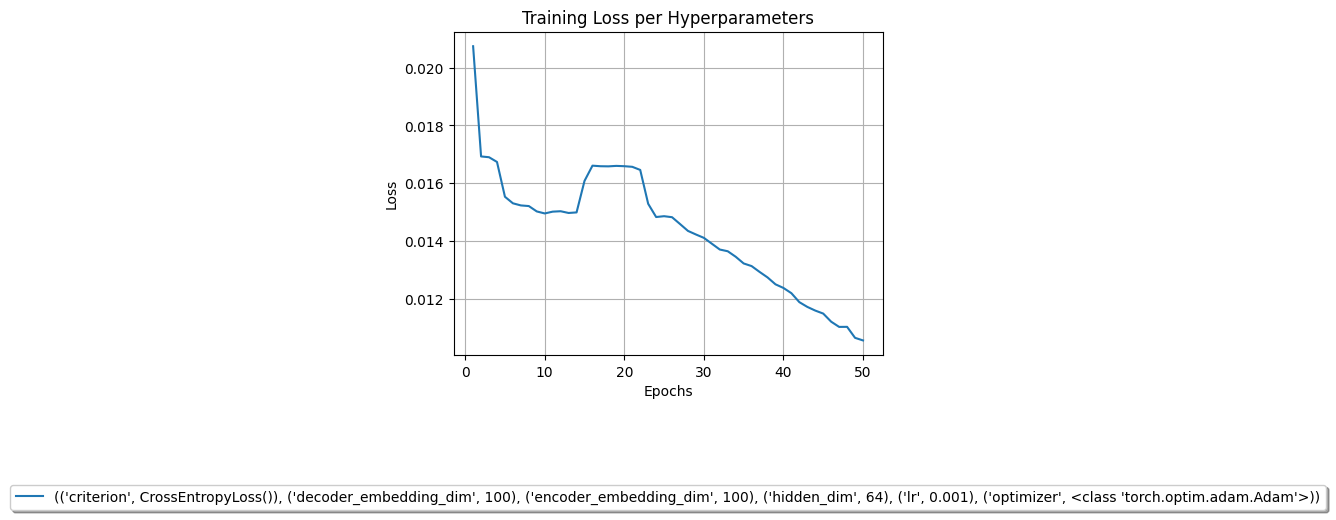

In [ ]:
# Plot hyperparameters tuning results
# Note: The optimal model represents in dark pink line
plt.figure(figsize=(10, 6))
for key, values in train_loss_per_params_m2.items():
    plt.plot(np.arange(1, 51), values, label=key)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Hyperparameters')
plt.grid(True)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), shadow=True, ncol=2)
plt.tight_layout();

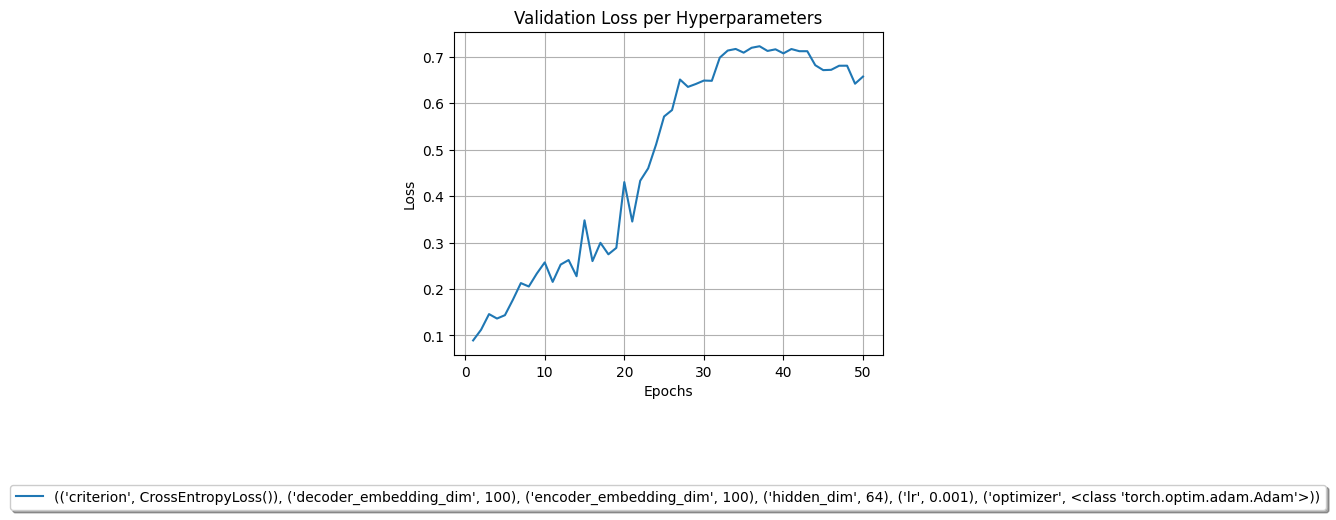

In [ ]:
# Plot hyperparameters tuning results
# Note: The optimal model represents in dark pink line -> overfitting
plt.figure(figsize=(10, 6))
for key, values in val_loss_per_params_m2.items():
    plt.plot(np.arange(1, 51), values, label=key)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss per Hyperparameters')
plt.grid(True)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), shadow=True, ncol=2)
plt.tight_layout();

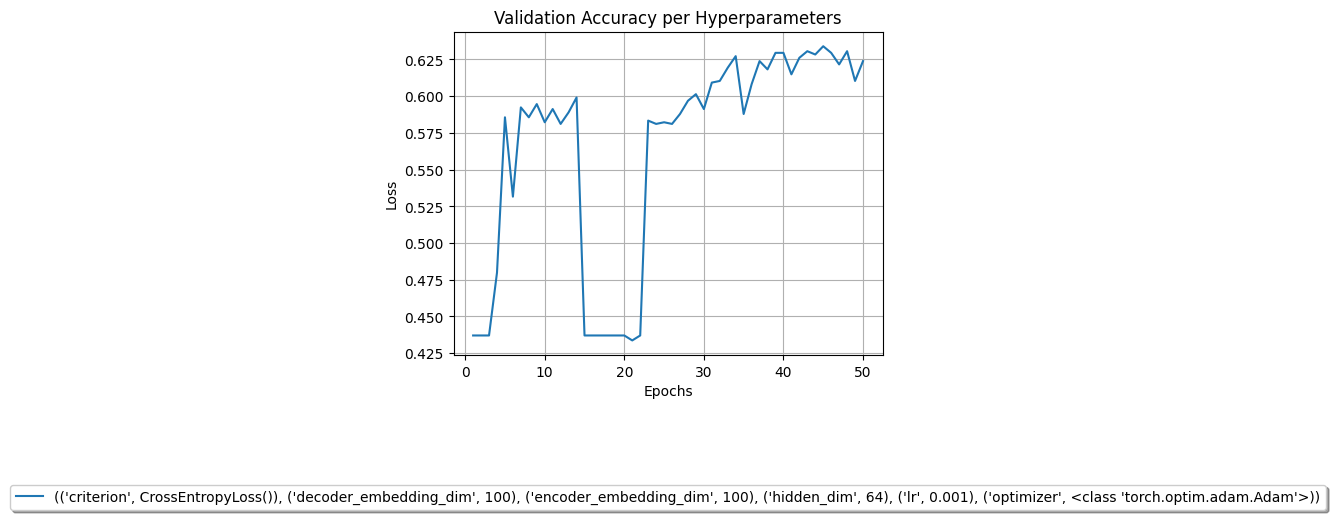

In [ ]:
# Plot hyperparameters tuning results
# Note: The optimal model represents in dark pink line
plt.figure(figsize=(10, 6))
for key, values in accuracy_per_params_m2.items():
    plt.plot(np.arange(1, 51), values, label=key)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Accuracy per Hyperparameters')
plt.grid(True)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), shadow=True, ncol=2)
plt.tight_layout();

In [ ]:
# Test the best model 2 from hyperparameter tuning on test set
def testing(model, test_loader, criterion, device):
    test_loss, test_accuracy = modelevalu(model, test_loader, criterion, device)
    print(f'Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}')

# Loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

# Load best model 2
best_val_model_2 = torch.load("best_val_model2_{'criterion': CrossEntropyLoss(), 'decoder_embedding_dim': 100, 'encoder_embedding_dim': 100, 'hidden_dim': 64, 'lr': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}.pt")
testing(best_val_model_2, test_data_loader, criterion, device)

Test Loss: 0.0146 - Test Accuracy: 0.6204


In [ ]:
def predict_sentiment(model, data_loader, device):
  model.eval()
  batch_predictions = []  # List to store prediction indices in each batch
  batch_ground_truths = []  # List to store ground truth indices in each batch

  predictions = []  # List to store all prediction indices
  ground_truths = []  # List to store all ground truth indices

  with torch.no_grad():
    for i, (input, polarity) in enumerate(data_loader):
      input = input.to(device)
      polarity = polarity.to(device)
      input = input.transpose(0, 1) # Transpose input to [input length, batch size]
      polarity = polarity.transpose(0, 1) # Transpose polarity to [polarity length, batch size]

      output = model(input, polarity, 0)  # Turn off teacher forcing

      # Extract sentiment positions from ground truth
      ground_truth = polarity[1, :]
      batch_ground_truths.append(ground_truth)

      # Get predictions
      prediction = torch.argmax(output, dim=2)

      # Extract sentiment positions from predictions
      predicted_ix = prediction[1, :]
      batch_predictions.append(predicted_ix)

  # Concatenate tensors and convert to lists
  for tensor in batch_predictions:
    predictions.extend(tensor.tolist())

  for tensor in batch_ground_truths:
    ground_truths.extend(tensor.tolist())

  return predictions, ground_truths

model2_prediction, model2_ground_truth = predict_sentiment(best_val_model_2, test_data_loader, device)
print(len(model2_prediction))
print(len(model2_ground_truth))

901
901


In [ ]:
model2_ground_truth

[4,
 5,
 3,
 5,
 5,
 4,
 5,
 4,
 4,
 5,
 5,
 4,
 5,
 4,
 3,
 5,
 5,
 4,
 5,
 5,
 4,
 4,
 4,
 3,
 5,
 4,
 5,
 4,
 5,
 4,
 4,
 3,
 3,
 4,
 4,
 5,
 4,
 3,
 3,
 4,
 5,
 4,
 4,
 5,
 4,
 3,
 4,
 3,
 4,
 3,
 5,
 5,
 4,
 3,
 4,
 3,
 3,
 5,
 4,
 3,
 4,
 3,
 4,
 3,
 4,
 4,
 3,
 4,
 5,
 5,
 3,
 5,
 4,
 5,
 3,
 4,
 3,
 4,
 5,
 4,
 5,
 5,
 3,
 4,
 4,
 5,
 5,
 4,
 4,
 5,
 5,
 4,
 3,
 4,
 4,
 4,
 5,
 5,
 4,
 5,
 4,
 4,
 3,
 4,
 5,
 5,
 4,
 4,
 3,
 5,
 4,
 4,
 3,
 3,
 4,
 3,
 4,
 5,
 5,
 4,
 5,
 4,
 5,
 3,
 5,
 3,
 5,
 3,
 4,
 5,
 3,
 4,
 5,
 3,
 4,
 5,
 5,
 5,
 4,
 5,
 4,
 5,
 4,
 3,
 5,
 5,
 4,
 5,
 5,
 4,
 4,
 4,
 5,
 3,
 4,
 3,
 4,
 5,
 4,
 3,
 5,
 3,
 4,
 5,
 4,
 4,
 5,
 4,
 4,
 3,
 5,
 4,
 4,
 3,
 3,
 3,
 5,
 3,
 4,
 3,
 5,
 5,
 4,
 5,
 4,
 4,
 4,
 3,
 3,
 4,
 4,
 5,
 4,
 4,
 5,
 4,
 5,
 5,
 4,
 4,
 4,
 5,
 4,
 3,
 4,
 5,
 3,
 4,
 5,
 4,
 3,
 5,
 5,
 4,
 4,
 5,
 5,
 3,
 4,
 4,
 5,
 5,
 3,
 4,
 5,
 4,
 4,
 3,
 5,
 3,
 4,
 3,
 5,
 4,
 3,
 4,
 5,
 4,
 5,
 4,
 3,
 4,
 4,
 3,
 3,
 4,
 5,
 4,
 4,
 5,


In [ ]:
model2_prediction

[4,
 3,
 3,
 5,
 5,
 4,
 4,
 5,
 5,
 5,
 5,
 4,
 5,
 4,
 5,
 5,
 5,
 4,
 5,
 5,
 4,
 4,
 4,
 3,
 5,
 4,
 3,
 4,
 4,
 4,
 4,
 3,
 3,
 4,
 4,
 5,
 4,
 5,
 3,
 4,
 5,
 4,
 3,
 4,
 4,
 5,
 5,
 5,
 4,
 3,
 5,
 3,
 4,
 3,
 4,
 3,
 5,
 5,
 4,
 4,
 3,
 3,
 3,
 4,
 5,
 4,
 4,
 3,
 4,
 5,
 4,
 4,
 5,
 3,
 4,
 4,
 3,
 3,
 5,
 4,
 5,
 4,
 5,
 4,
 4,
 5,
 5,
 4,
 3,
 3,
 3,
 4,
 5,
 3,
 4,
 4,
 5,
 5,
 4,
 5,
 4,
 4,
 5,
 4,
 5,
 5,
 4,
 3,
 3,
 5,
 4,
 3,
 5,
 4,
 4,
 3,
 4,
 4,
 5,
 4,
 5,
 4,
 5,
 3,
 4,
 4,
 4,
 5,
 4,
 5,
 5,
 4,
 5,
 3,
 5,
 4,
 5,
 5,
 4,
 5,
 4,
 5,
 4,
 3,
 5,
 5,
 4,
 5,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 4,
 4,
 3,
 4,
 3,
 3,
 5,
 4,
 4,
 4,
 4,
 3,
 3,
 4,
 3,
 5,
 4,
 3,
 3,
 3,
 5,
 5,
 4,
 4,
 5,
 5,
 5,
 4,
 5,
 4,
 5,
 3,
 5,
 5,
 4,
 4,
 5,
 4,
 4,
 5,
 3,
 5,
 5,
 4,
 4,
 3,
 4,
 5,
 3,
 4,
 3,
 4,
 4,
 5,
 4,
 3,
 5,
 3,
 3,
 4,
 5,
 4,
 3,
 4,
 4,
 3,
 4,
 5,
 4,
 5,
 4,
 4,
 5,
 4,
 5,
 4,
 5,
 5,
 3,
 3,
 4,
 5,
 4,
 4,
 4,
 3,
 4,
 3,
 5,
 5,
 4,
 5,
 4,
 4,
 4,


In [ ]:
def get_keys_from_value(dictionary, values):
    keys = []
    for value in values:
        for key, val in dictionary.items():
            if val == value:
                keys.append(key)
    return keys

model2_prediction_coverted = get_keys_from_value(decoder_word_to_ix, model2_prediction)
print(model2_prediction_coverted)

model2_ground_truth_coverted = get_keys_from_value(decoder_word_to_ix, model2_ground_truth)
print(model2_ground_truth_coverted)

['neutral', 'neutral', 'neutral', 'negative', 'negative', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'negative', 'neutral', 'negative', 'neutral', 'neutral', 'negative', 'negative', 'neutral', 'negative', 'negative', 'neutral', 'neutral', 'positive', 'positive', 'negative', 'neutral', 'positive', 'positive', 'neutral', 'neutral', 'neutral', 'positive', 'positive', 'neutral', 'neutral', 'negative', 'neutral', 'negative', 'positive', 'positive', 'negative', 'neutral', 'neutral', 'neutral', 'neutral', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'neutral', 'positive', 'positive', 'positive', 'positive', 'negative', 'neutral', 'neutral', 'positive', 'negative', 'neutral', 'positive', 'positive', 'positive', 'neutral', 'positive', 'neutral', 'negative', 'neutral', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'neutral', 'neutral', 'negative', 'neutral', 'negative', 'neutral', 'neutral', 'positive', 'neg

In [ ]:
# labels = ['positive', 'neutral', 'negative']
# from sklearn.metrics import classification_report
# print(classification_report([labels[int(i-3)] for i in model2_ground_truth],
#                              [labels[int(i-3)] for i in model2_prediction], digits=4))

labels = ['positive', 'neutral', 'negative']
from sklearn.metrics import classification_report
print(classification_report(model2_prediction, model2_ground_truth, target_names=labels))

              precision    recall  f1-score   support

    positive       0.53      0.44      0.49       295
     neutral       0.72      0.69      0.70       410
    negative       0.49      0.66      0.57       196

    accuracy                           0.60       901
   macro avg       0.58      0.60      0.58       901
weighted avg       0.61      0.60      0.60       901



## Model 3: Fine Tuned Dual Bi-LSTM Models with Attention for Sentence and Aspect

### Data preparation

In [ ]:
# Add <ASP> between sentence and aspect for encoder input
# Ex. ['good', 'sit', 'food', 'area', 'go', 'upright', 'citizen', 'brigade', 'garden', 'place', '<ASP>', 'food']
def add_asp(sentence_token_list, aspect_token_list):
  output = []
  for sublist1, sublist2 in zip(sentence_token_list, aspect_token_list):
    sent = sublist1 + ['<ASP>'] + sublist2
    output.append(sent)
  return output

# Add <ASP> to training set
train_input_token_list = add_asp(train_sentence_token_list, train_aspect_token_list)

# Add <ASP> to validation set
val_input_token_list = add_asp(val_sentence_token_list, val_aspect_token_list)

# Add <ASP> to test set
test_input_token_list = add_asp(test_sentence_token_list, test_aspect_token_list)

print("Sample tokenize sentence after add <ASP>:\n", train_input_token_list[0])

Sample tokenize sentence after add <ASP>:
 ['good', 'sit', 'food', 'area', 'go', 'upright', 'citizen', 'brigade', 'garden', 'place', '<ASP>', 'food']


In [ ]:
# Adding special tokens for generation: <BOS> indicates beginning of sentence, <EOS> means end of sentence
def add_special_token(token_list):
  s = [["<BOS>"] + s for s in token_list]
  return [s + ["<EOS>"] for s in s]

# Add special tokens to training set
train_src_tokens = add_special_token(train_input_token_list)
train_trg_tokens = add_special_token(train_polarity_token_list)

# Add special tokens to validation set
val_src_tokens = add_special_token(val_input_token_list)
val_trg_tokens = add_special_token(val_polarity_token_list)

# Add special tokens to test set
test_src_tokens = add_special_token(test_input_token_list)
test_trg_tokens = add_special_token(test_polarity_token_list)

assert len(train_src_tokens)==len(train_trg_tokens)
print("Sample tokenize sentence after add <BOS> and <EOS>:")
print(train_src_tokens[0])
print(train_trg_tokens[0])

Sample tokenize sentence after add <BOS> and <EOS>:
['<BOS>', 'good', 'sit', 'food', 'area', 'go', 'upright', 'citizen', 'brigade', 'garden', 'place', '<ASP>', 'food', '<EOS>']
['<BOS>', 'positive', '<EOS>']


In [ ]:
# Here we simply use the maximum sentence length
MAX_LENGTH = max(len(sublist) for sublist in train_src_tokens)
print("Maximum length:", MAX_LENGTH)

Maximum length: 45


In [ ]:
# Set up a vocab to index dictionary for encoder
encoder_word_to_ix = {'<PAD>': 0, # Padding token
             '<OOV>': 1, # Out Of Vocabulary token
             '<BOS>': 2, # Beginning of the sentence
             '<EOS>': 3, # End of the sentence
             '<ASP>': 4} # Aspect of the sentence

for sentence in train_src_tokens:
    for word in sentence:
        if word not in encoder_word_to_ix:
            encoder_word_to_ix[word] = len(encoder_word_to_ix)

encoder_word_list = list(encoder_word_to_ix.keys())

# First 15 encoder vocabularies
print('First 15  encoder vocabularies:', encoder_word_list[:15])

First 15  encoder vocabularies: ['<PAD>', '<OOV>', '<BOS>', '<EOS>', '<ASP>', 'good', 'sit', 'food', 'area', 'go', 'upright', 'citizen', 'brigade', 'garden', 'place']


In [ ]:
# Set up a vocab to index dictionary for decoder
decoder_word_to_ix = {
    '<PAD>': 0, # Padding
    '<BOS>': 1, # Beginning of the sentence
    '<EOS>': 2, # End of the sentence
}

for sentence in train_trg_tokens:
    for word in sentence:
        if word not in decoder_word_to_ix:
            decoder_word_to_ix[word] = len(decoder_word_to_ix)

decoder_word_list = list(decoder_word_to_ix.keys())

# Decoder vocabularies
print('Decoder vocabularies:', decoder_word_list)

Decoder vocabularies: ['<PAD>', '<BOS>', '<EOS>', 'positive', 'neutral', 'negative']


In [ ]:
# Pad all sentences into the max length
train_src_tokens = [sublist + ['<PAD>'] * (MAX_LENGTH - len(sublist)) for sublist in train_src_tokens]
train_trg_tokens = [sublist + ['<PAD>'] * (MAX_LENGTH - len(sublist)) for sublist in train_trg_tokens]

val_src_tokens = [sublist + ['<PAD>'] * (MAX_LENGTH - len(sublist)) for sublist in val_src_tokens]
val_trg_tokens = [sublist + ['<PAD>'] * (MAX_LENGTH - len(sublist)) for sublist in val_trg_tokens]

test_src_tokens = [sublist + ['<PAD>'] * (MAX_LENGTH - len(sublist)) for sublist in test_src_tokens]
test_trg_tokens = [sublist + ['<PAD>'] * (MAX_LENGTH - len(sublist)) for sublist in test_trg_tokens]

assert len(train_src_tokens[0]) == len(train_trg_tokens[0])
print('Sample tokenize sentence after padding:')
print(train_src_tokens[0])
print(train_trg_tokens[0])

Sample tokenize sentence after padding:
['<BOS>', 'good', 'sit', 'food', 'area', 'go', 'upright', 'citizen', 'brigade', 'garden', 'place', '<ASP>', 'food', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<BOS>', 'positive', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


In [ ]:
class Seq2SeqDataset(Dataset):
  def __init__(self, src_data, trg_data, encoder_word_to_ix, decoder_word_to_ix):
    self.src_data = self.input2index(src_data, encoder_word_to_ix)
    self.trg_data = self.input2index(trg_data, decoder_word_to_ix)

  def __len__(self):
      return len(self.src_data)

  def __getitem__(self, idx):
      src_seq = torch.tensor(self.src_data[idx])
      trg_seq = torch.tensor(self.trg_data[idx])
      return src_seq, trg_seq

  def input2index(self, data, word2index):
    input_index_list = []
    for sent in data:
        sent_indices = []
        for w in sent:
            if w in word2index:
                sent_indices.append(word2index[w])
            else:
                # If word is not in vocabulary, use special OOV token index
                sent_indices.append(word2index['<OOV>'])
        input_index_list.append(sent_indices)
    return input_index_list

### Model


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, n_layers, dropout, pad_id):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_id)  # Encoder embedding layer
        self.RNN = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)  # LSTM layer for processing the embedded input sequence

    def forward(self, input):
        embedded = self.embedding(input)
        outputs, (hidden, cell) = self.RNN(embedded)  # Pass the embedded input through the LSTM
        return outputs, (hidden, cell)  # Return encoder outputs, hidden and cell states

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        # Linear layer to transform concatenated hidden states from encoder and decoder
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        # Linear layer to compute unnormalized attention scores
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs, src_mask):
        src_len = encoder_outputs.shape[0]

        # Repeat the decoder hidden state src_len times for each batch element
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)

        # Reshape encoder outputs to match the dimensions for concatenation
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        # Concatenate hidden state from decoder with encoder outputs and apply tanh activation
        scores = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))

        # Compute unnormalized attention scores
        attention = self.v(scores).squeeze(2)

        # Apply mask to ignore padding positions in source sentences
        attention = attention.masked_fill(src_mask == 0, -1e10)

        # Apply softmax to obtain normalized attention weights
        return F.softmax(attention, dim=1)

class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers, dropout, pad_id, attention):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, embedding_dim, padding_idx=pad_id)  # Embedding layer
        self.RNN = nn.LSTM(embedding_dim + hidden_dim, hidden_dim, n_layers, dropout=dropout)  # LSTM with concatenated input
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Linear layer for final output
        self.attention = attention  # Attention layer

    def forward(self, input, hidden, cell, encoder_outputs, src_mask):
        input = input.unsqueeze(0)  # Add time dimension: [batch_size] -> [1, batch_size]
        embedded = self.embedding(input)
        # Calculate attention weights
        a = self.attention(hidden[-1], encoder_outputs, src_mask)  # [batch_size, src_len]
        a = a.unsqueeze(1)  # Add extra dimension for batch matrix multiplication: [batch_size, 1, src_len]

        # Reshape encoder outputs
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # [batch_size, src_len, hidden_dim]

        # Compute weighted sum of encoder outputs
        weighted = torch.bmm(a, encoder_outputs)  # [batch_size, 1, hidden_dim]
        weighted = weighted.permute(1, 0, 2)  # [1, batch_size, hidden_dim]

        # Concatenate weighted encoder outputs with embedded input
        rnn_input = torch.cat((embedded, weighted), dim=2)  # [1, batch_size, embedding_dim + hidden_dim]

        # Pass through LSTM
        output, (hidden, cell) = self.RNN(rnn_input, (hidden, cell))  # [1, batch_size, hidden_dim]
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        # Generate prediction
        prediction = self.fc(torch.cat((output, weighted), dim=1))  # [batch_size, output_dim]
        return prediction, hidden, cell, a.squeeze(1)  # Return prediction, new hidden & cell states, and attention weights

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio, src_mask):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        # Tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # Tensor to store attention scores
        attentions = torch.zeros(trg_len, batch_size, src.shape[0]).to(self.device)

        # Pass through encoder
        encoder_outputs, (hidden, cell) = self.encoder(src)

        # First input to the decoder is the <BOS> token
        input = trg[0, :]

        for t in range(1, trg_len):
            # Pass through decoder
            output, hidden, cell, attention = self.decoder(input, hidden, cell, encoder_outputs, src_mask)
            outputs[t] = output  # Store output
            attentions[t] = attention  # Store attention scores

            # Determine if teacher forcing will be used
            teacher_force = random.random() < teacher_forcing_ratio

            # Get the highest predicted token
            predicted = output.argmax(1)

            # Use actual next token or predicted token
            input = trg[t] if teacher_force else predicted

        return outputs, attentions  # Return outputs and attention scores


In [ ]:
def create_mask(src, pad_token_idx):
    return (src != pad_token_idx).permute(1, 0)

def modeltraining(model, data_loader, optimizer, criterion, lr, teacher_forcing_ratio, device):
  epoch_loss = 0
  correct_predictions = 0
  total_predictions = 0

  # Loss function and optimizer
  criterion = nn.CrossEntropyLoss(ignore_index=pad_index)
  optimizer = optimizer(model.parameters(), lr=lr)

  # Set model in training mode
  model.train()

  for i, (batch_input, batch_polarity) in enumerate(data_loader):
    input = batch_input.to(device)
    polarity = batch_polarity.to(device)
    src_mask = create_mask(input, encoder_word_to_ix['<PAD>']).to(device)

    input = input.transpose(0, 1) # Transpose input to [input length, batch size]
    polarity = polarity.transpose(0, 1) # Transpose polarity to [polarity length, batch size]
    src_mask = src_mask.transpose(0, 1) # [input length, batch size]

    optimizer.zero_grad()
    output, attentions = model(input, polarity, teacher_forcing_ratio, src_mask)

    # Get predictions
    predictions = torch.argmax(output, dim=2)

    # Extract only sentiment position for accuracy calculation
    target = polarity[1, :]
    predicted = predictions[1, :]

    # Count correct predictions for this batch
    correct_predictions += torch.sum(predicted == target).item()
    total_predictions += len(target)

    # Calculate loss
    output_dim = output.shape[-1]
    output = output[1:].view(-1, output_dim)
    trg = polarity[1:].reshape(-1)
    loss = criterion(output, trg)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()

  # Calculate accuracy and total loss
  accuracy = correct_predictions / total_predictions
  total_loss = epoch_loss / total_predictions

  return total_loss, accuracy, attentions

def modelevalu(model, data_loader, criterion, device):
  epoch_loss = 0
  correct_predictions = 0
  total_predictions = 0

  # Set the model to evaluation mode
  model.eval()

  # Disable evaluation gradient computation
  with torch.no_grad():

    for i, (batch_input, batch_polarity) in enumerate(data_loader):
      input = batch_input.to(device)
      polarity = batch_polarity.to(device)
      src_mask = create_mask(input, encoder_word_to_ix['<PAD>']).to(device)

      input = input.transpose(0, 1) # Transpose input to [input length, batch size]
      polarity = polarity.transpose(0, 1) # Transpose polarity to [polarity length, batch size]
      src_mask = src_mask.transpose(0, 1)

      output, attentions = model(input, polarity, 0, src_mask) # Turn off teacher forcing

      # Get predictions
      predictions = torch.argmax(output, dim=2)

      # Extract only sentiment position for accuracy calculation
      target = polarity[1, :]
      predicted = predictions[1, :]

      # Count correct predictions for this batch
      correct_predictions += torch.sum(predicted == target).item()
      total_predictions += len(target)

      # Calculate loss
      output_dim = output.shape[-1]
      output = output[1:].view(-1, output_dim)
      trg = polarity[1:].reshape(-1)
      loss = criterion(output, trg)
      epoch_loss += loss.item()

    # Calculate accuracy and total loss
    accuracy = correct_predictions / total_predictions
    total_loss = epoch_loss / total_predictions

  return total_loss, accuracy, attentions

In [ ]:
# Hyperparameters Tuning

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fixed inputs
input_dim = len(encoder_word_to_ix)
output_dim = len(decoder_word_to_ix)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pad_index = encoder_word_to_ix['<PAD>']
batch_size = 32
n_layers = 1
encoder_dropout = 0.5 # the units in the encoder would be randomly set to zero during each training epoch
decoder_dropout = 0.5  # the units in the decoder would be randomly set to zero during each training epoch
teacher_forcing_ratio = 0.1 # avoid overfitting

# Convert tokens to index
train_data = Seq2SeqDataset(train_src_tokens, train_trg_tokens, encoder_word_to_ix, decoder_word_to_ix)
val_data = Seq2SeqDataset(val_src_tokens, val_trg_tokens, encoder_word_to_ix, decoder_word_to_ix)
test_data = Seq2SeqDataset(test_src_tokens, test_trg_tokens, encoder_word_to_ix, decoder_word_to_ix)

# Data Loader
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False)
val_data_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=False)
test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=False)


hyperparameters_grid = {
    'criterion': [nn.CrossEntropyLoss()],
    'optimizer': [optim.Adam],
    'lr': [0.001],
    'encoder_embedding_dim': [100],
    'decoder_embedding_dim': [100],
    'hidden_dim': [64]
}

# Fixed inputs
epochs = 50
best_params_m3 = None
best_accuracy_per_params_m3 = {}
accuracy_per_params_m3 = {}
train_loss_per_params_m3 = {}
val_loss_per_params_m3 = {}
model_number = 'model3'

for params in ParameterGrid(hyperparameters_grid):

  param_key = tuple(params.items())
  print(f"Starting training with parameters: {param_key}")

  # Initialize tracking
  best_accuracy_per_params_m3[param_key] = -1
  train_loss_per_params_m3[param_key] = []
  val_loss_per_params_m3[param_key] = []
  accuracy_per_params_m3[param_key] = []

  # Set seed for reproducibility
  seed = 42
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  random.seed(seed)
  np.random.seed(seed)

  # Define model
  attention = Attention(params['hidden_dim'])
  encoder = Encoder(input_dim, params['encoder_embedding_dim'], params['hidden_dim'], n_layers, encoder_dropout, encoder_word_to_ix['<PAD>'])
  decoder = Decoder(output_dim, params['decoder_embedding_dim'], params['hidden_dim'], n_layers, decoder_dropout, decoder_word_to_ix['<PAD>'], attention)
  model = Seq2Seq(encoder, decoder, device).to(device)

  for epoch in range(epochs):
    train_loss, train_accuracy, _ = modeltraining(model, train_data_loader, params['optimizer'], params['criterion'], params['lr'], teacher_forcing_ratio, device)
    val_loss, val_accuracy, _ = modelevalu(model, val_data_loader, params['criterion'], device)

    # Append loss and accuracy to lists stored in dictionaries
    train_loss_per_params_m3[param_key].append(train_loss)
    val_loss_per_params_m3[param_key].append(val_loss)
    accuracy_per_params_m3[param_key].append(val_accuracy)

    if epoch % 10 == 9:
        print(f'Epoch {epoch}/{epochs} - Training loss: {train_loss:.4f} - Validation loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}')

    # Save the best accuracy model
    if val_accuracy > best_accuracy_per_params_m3[param_key]:
        best_accuracy_per_params_m3[param_key] = round(val_accuracy, 4)
        model_name = f"best_val_{model_number}_{params}.pt"
        torch.save(model, model_name)

  print(f'Completed training with parameters: {params}. \nBest Accuracy: {best_accuracy_per_params_m3[param_key]:.4f}')
  print("=" * 150)

Starting training with parameters: (('criterion', CrossEntropyLoss()), ('decoder_embedding_dim', 100), ('encoder_embedding_dim', 100), ('hidden_dim', 64), ('lr', 0.001), ('optimizer', <class 'torch.optim.adam.Adam'>))
Epoch 9/50 - Training loss: 0.0066 - Validation loss: 0.8414 - Validation Accuracy: 0.6227
Epoch 19/50 - Training loss: 0.0024 - Validation loss: 0.9041 - Validation Accuracy: 0.6194
Epoch 29/50 - Training loss: 0.0012 - Validation loss: 0.9934 - Validation Accuracy: 0.5811
Epoch 39/50 - Training loss: 0.0008 - Validation loss: 1.0301 - Validation Accuracy: 0.5811
Epoch 49/50 - Training loss: 0.0005 - Validation loss: 1.0719 - Validation Accuracy: 0.5980
Completed training with parameters: {'criterion': CrossEntropyLoss(), 'decoder_embedding_dim': 100, 'encoder_embedding_dim': 100, 'hidden_dim': 64, 'lr': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}. 
Best Accuracy: 0.6498


In [ ]:
# Find the best accuracy across all sets of hyperparameters (Model 2)
best_accuracy = -1
for params, accuracy in best_accuracy_per_params_m3.items():
  if accuracy > best_accuracy:
    best_accuracy = accuracy
    m2optpara = params

print("Best Hyperparameters for Model 2:", m2optpara)
print("Best Accuracy achieved from Model 2:", best_accuracy)

Best Hyperparameters for Model 2: (('criterion', CrossEntropyLoss()), ('decoder_embedding_dim', 100), ('encoder_embedding_dim', 100), ('hidden_dim', 64), ('lr', 0.001), ('optimizer', <class 'torch.optim.adam.Adam'>))
Best Accuracy achieved from Model 2: 0.6498


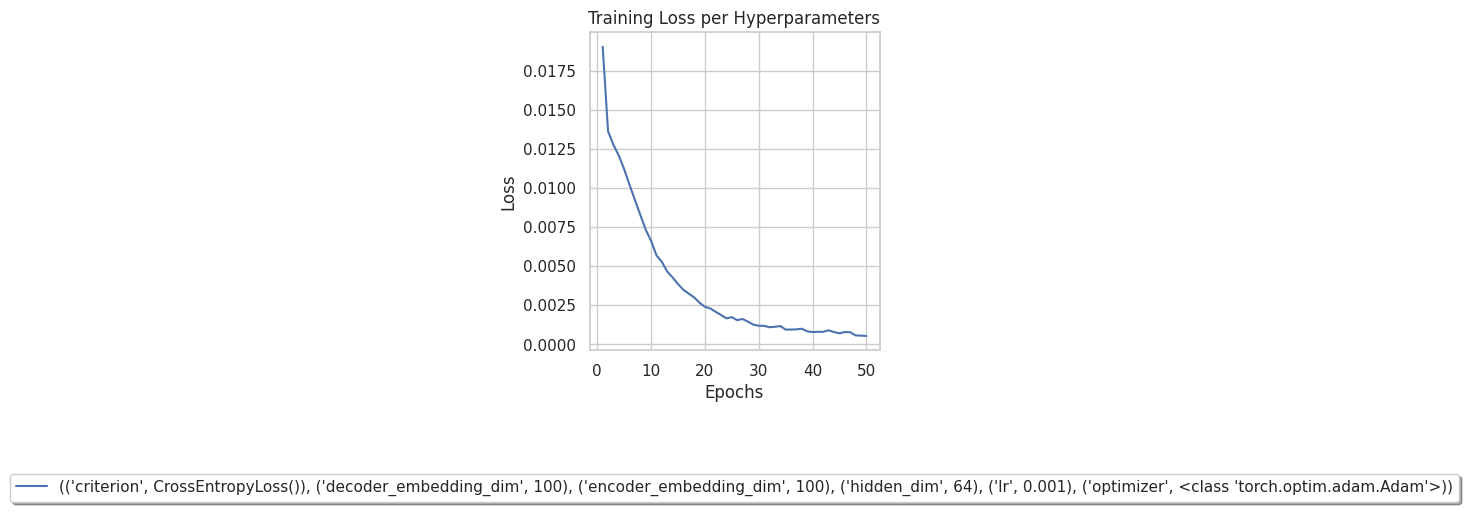

In [ ]:
# Plot hyperparameters tuning results
# Note: The optimal model represents in dark pink line
plt.figure(figsize=(10, 6))
for key, values in train_loss_per_params_m3.items():
    plt.plot(np.arange(1, epochs+1), values, label=key)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Hyperparameters')
plt.grid(True)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), shadow=True, ncol=2)
plt.tight_layout();

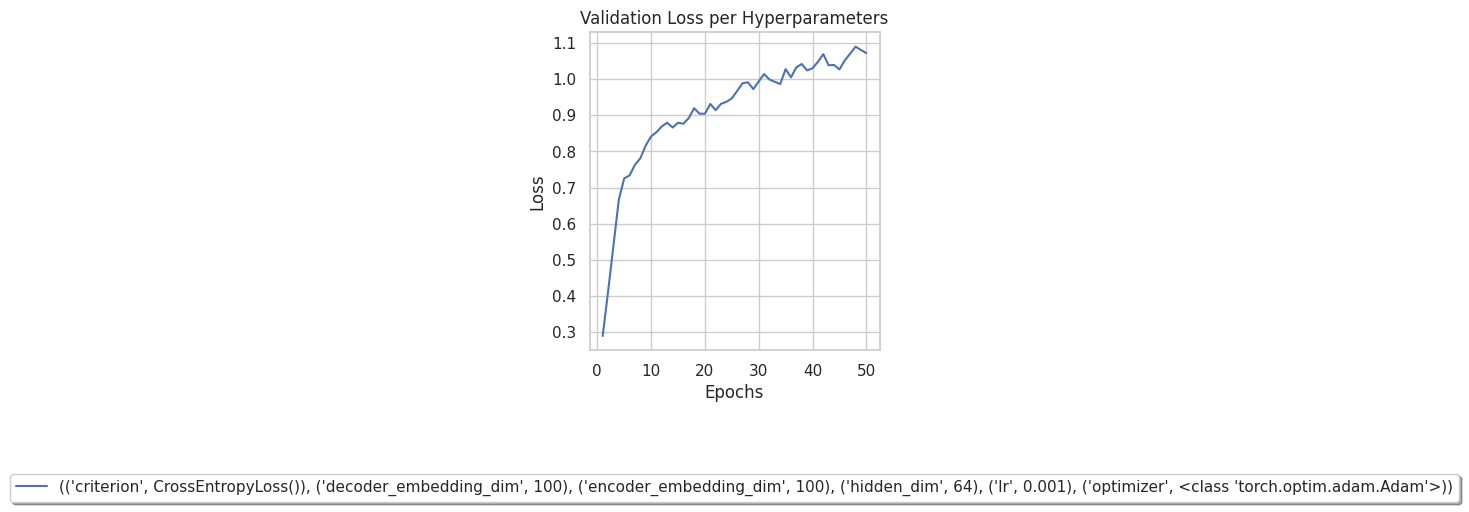

In [ ]:
# Plot hyperparameters tuning results
# Note: The optimal model represents in dark pink line -> overfitting
plt.figure(figsize=(10, 6))
for key, values in val_loss_per_params_m3.items():
    plt.plot(np.arange(1, epochs+1), values, label=key)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss per Hyperparameters')
plt.grid(True)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), shadow=True, ncol=2)
plt.tight_layout();

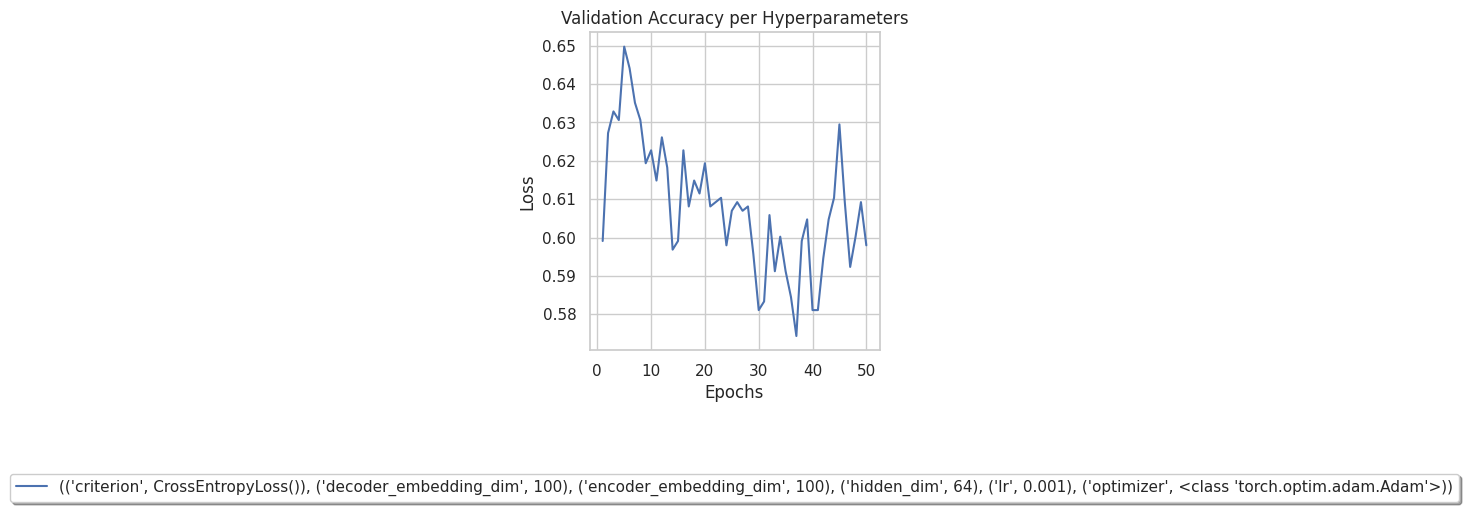

In [ ]:
# Plot hyperparameters tuning results
# Note: The optimal model represents in dark pink line
plt.figure(figsize=(10, 6))
for key, values in accuracy_per_params_m3.items():
    plt.plot(np.arange(1, epochs+1), values, label=key)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Accuracy per Hyperparameters')
plt.grid(True)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), shadow=True, ncol=2)
plt.tight_layout();

In [ ]:
# Test the best model 3 from hyperparameter tuning on test set

# Loss function
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

# Load best model 2
# best_val_model_2 = torch.load("best_val_model2_{'criterion': CrossEntropyLoss(), 'decoder_embedding_dim': 100, 'encoder_embedding_dim': 100, 'hidden_dim': 64, 'lr': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}.pt")
best_val_model_3 = torch.load("best_val_model3_{'criterion': CrossEntropyLoss(), 'decoder_embedding_dim': 100, 'encoder_embedding_dim': 100, 'hidden_dim': 64, 'lr': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}.pt")
test_loss, test_accuracy, _ = modelevalu(best_val_model_3, test_data_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.0134 - Test Accuracy: 0.6382


In [ ]:
def predict_sentiment(model, data_loader, device):
  model.eval()
  batch_predictions = []  # List to store prediction indices in each batch
  batch_ground_truths = []  # List to store ground truth indices in each batch

  predictions = []  # List to store all prediction indices
  ground_truths = []  # List to store all ground truth indices

  with torch.no_grad():
    for i, (input, polarity) in enumerate(data_loader):
      input = input.to(device)
      polarity = polarity.to(device)
      src_mask = create_mask(input, encoder_word_to_ix['<PAD>']).to(device)

      input = input.transpose(0, 1) # Transpose input to [input length, batch size]
      polarity = polarity.transpose(0, 1) # Transpose polarity to [polarity length, batch size]
      src_mask = src_mask.transpose(0, 1)

      output, _ = model(input, polarity, 0, src_mask)  # Turn off teacher forcing

      # Extract sentiment positions from ground truth
      ground_truth = polarity[1, :]
      batch_ground_truths.append(ground_truth)

      # Get predictions
      prediction = torch.argmax(output, dim=2)

      # Extract sentiment positions from predictions
      predicted_ix = prediction[1, :]
      batch_predictions.append(predicted_ix)

  # Concatenate tensors and convert to lists
  for tensor in batch_predictions:
    predictions.extend(tensor.tolist())

  for tensor in batch_ground_truths:
    ground_truths.extend(tensor.tolist())

  return predictions, ground_truths

model3_prediction, model3_ground_truth = predict_sentiment(best_val_model_3, test_data_loader, device)
print(len(model3_prediction))
print(len(model3_ground_truth))

# labels = ['positive', 'neutral', 'negative']
# from sklearn.metrics import classification_report
# print(classification_report([labels[int(i-3)] for i in model3_ground_truth],
#                              [labels[int(i-3)] for i in model3_prediction], digits=4))

labels = ['positive', 'neutral', 'negative']
from sklearn.metrics import classification_report
print(classification_report(model3_prediction, model3_ground_truth, target_names=labels))

901
901
              precision    recall  f1-score   support

    positive       0.49      0.51      0.50       235
     neutral       0.80      0.70      0.75       449
    negative       0.53      0.64      0.58       217

    accuracy                           0.64       901
   macro avg       0.61      0.62      0.61       901
weighted avg       0.66      0.64      0.64       901



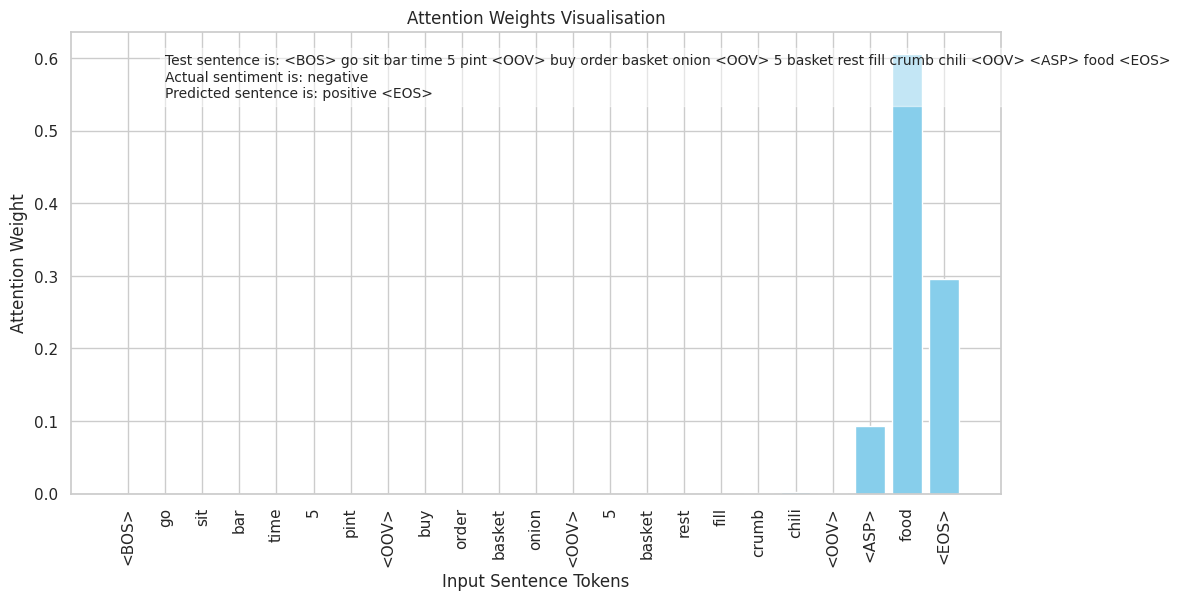

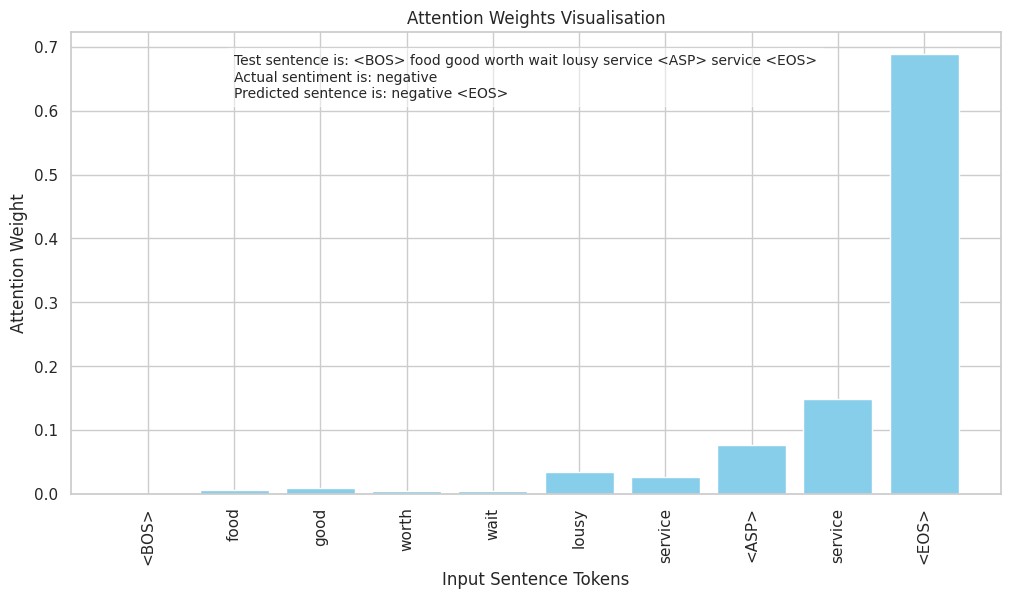

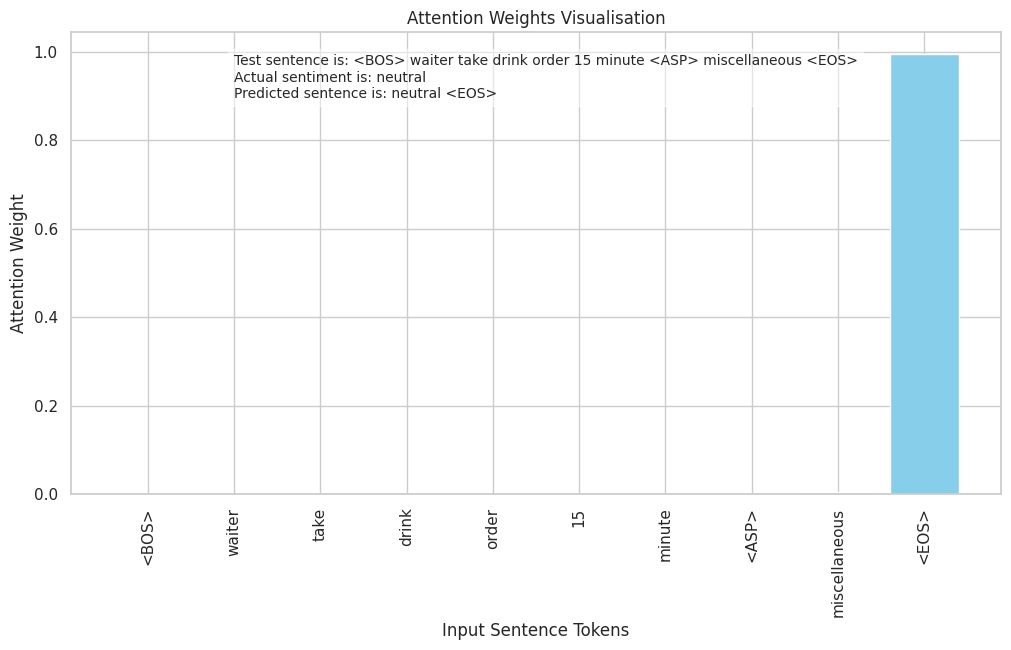

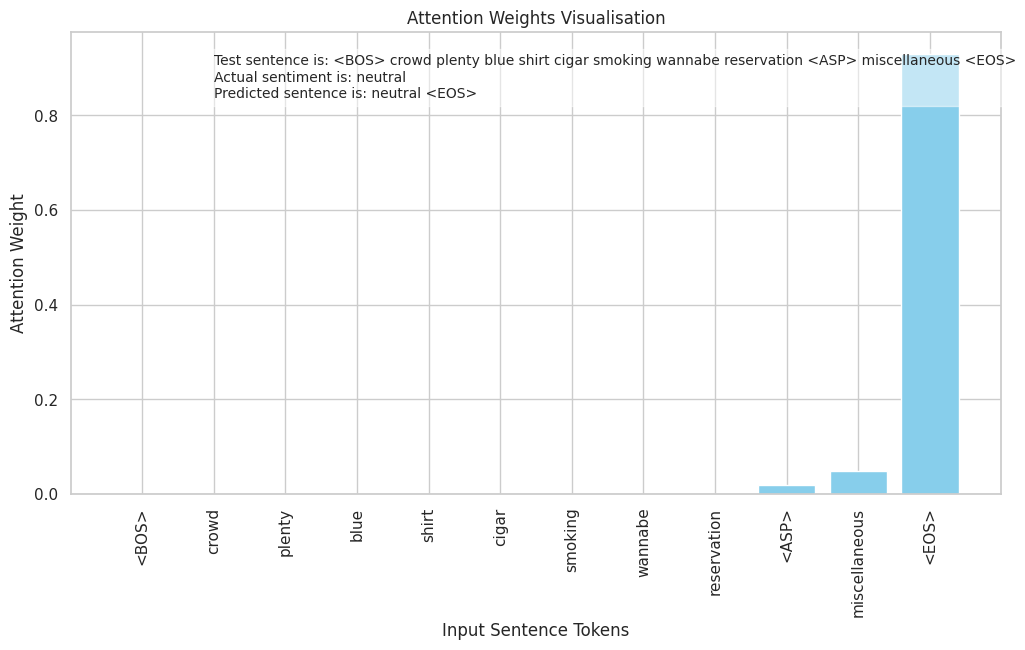

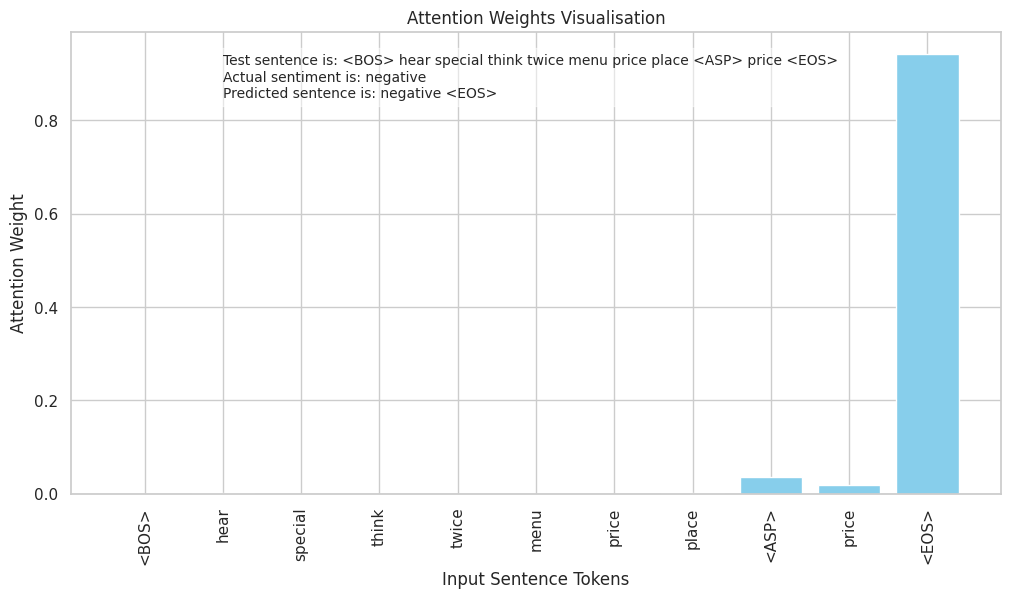

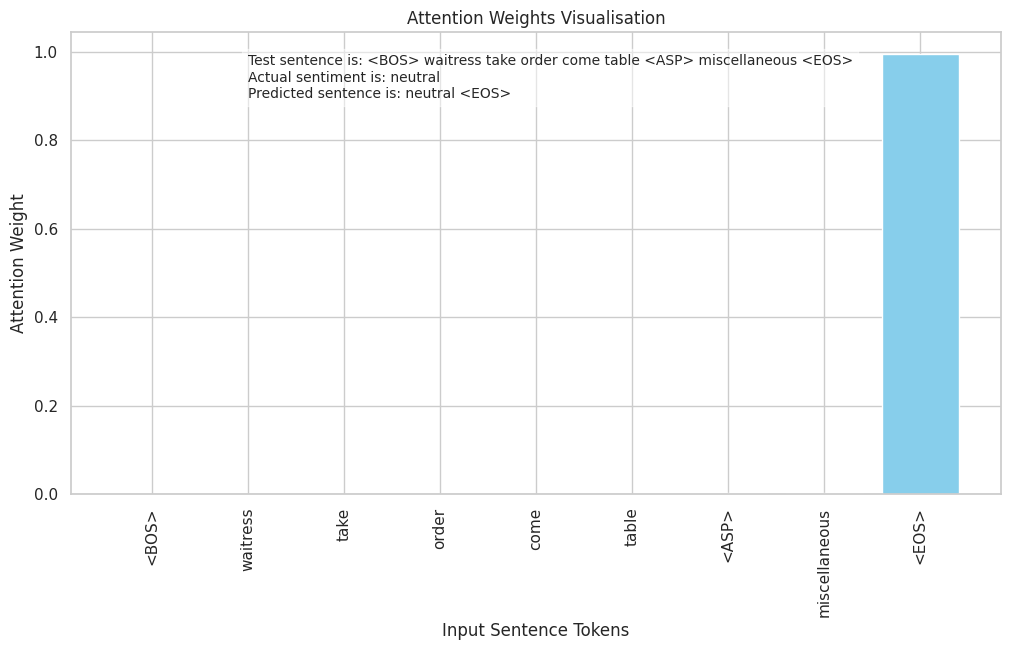

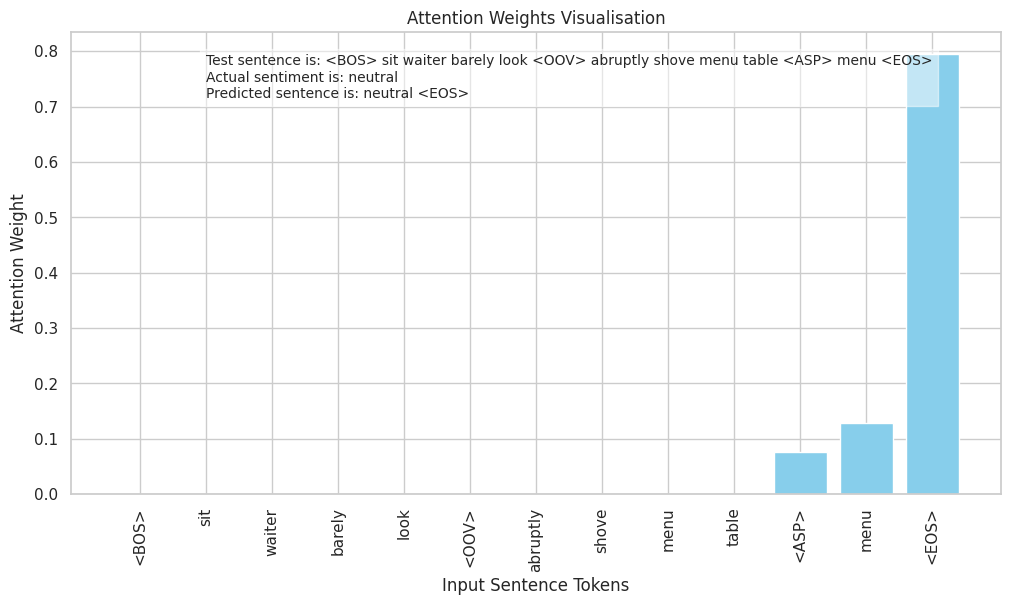

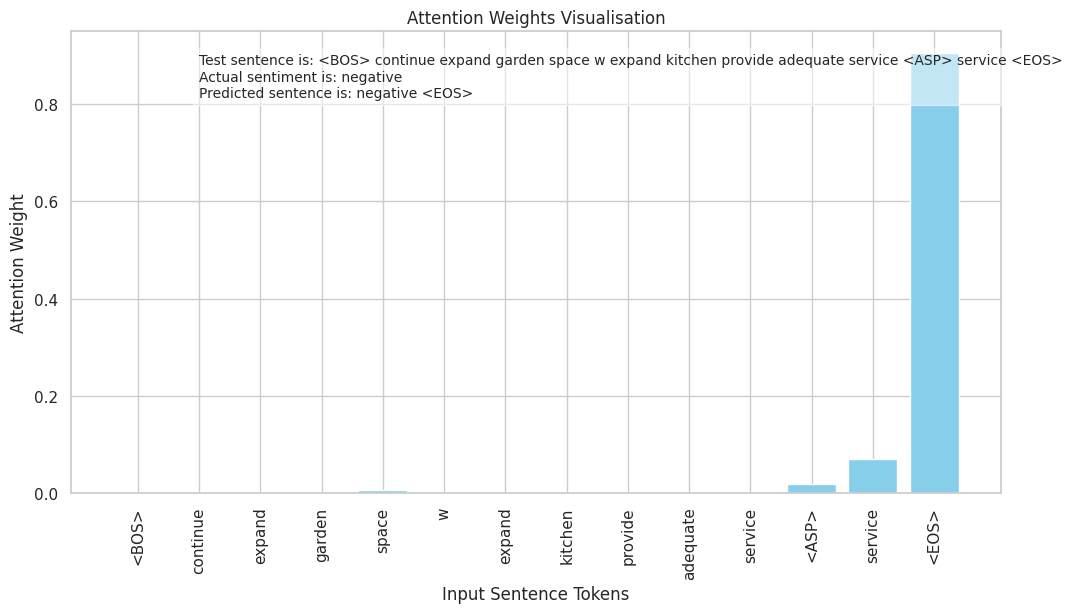

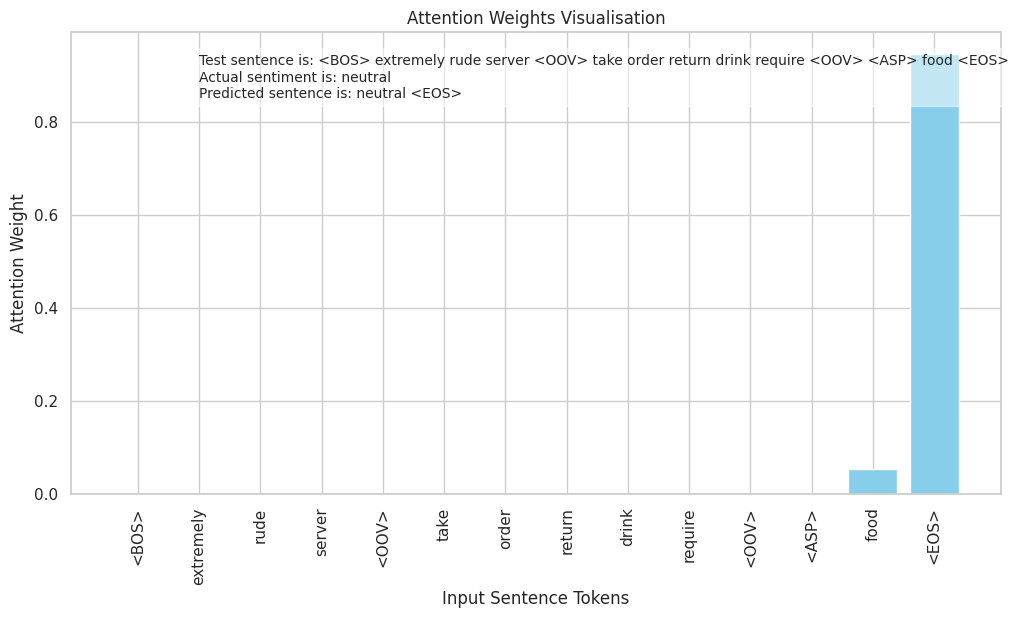

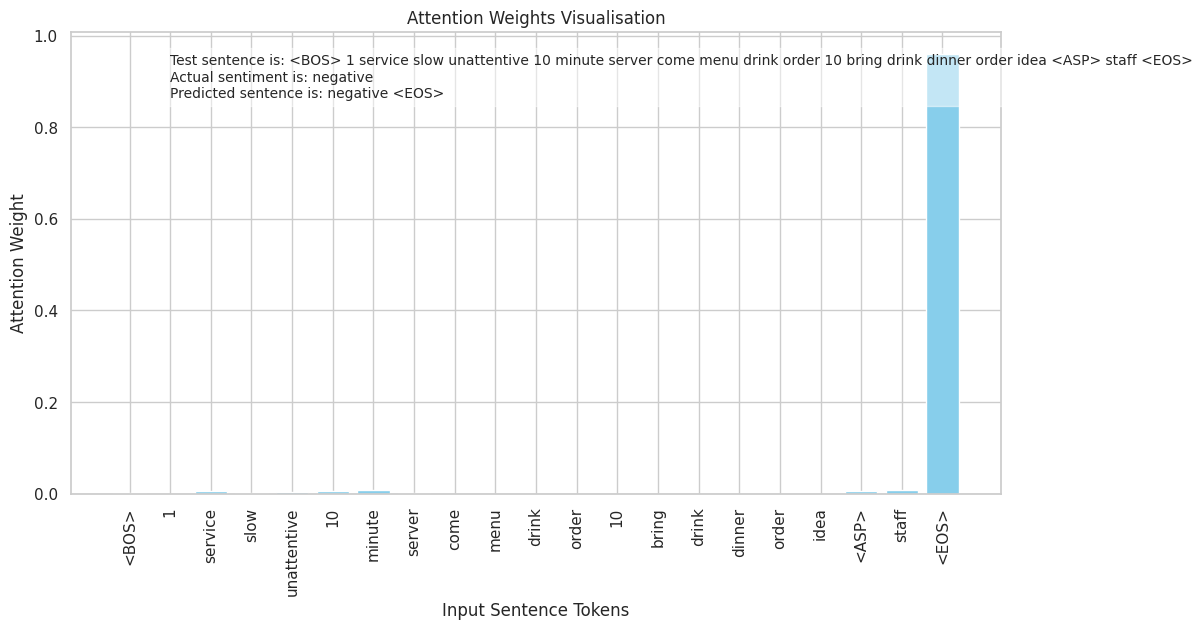

In [ ]:
import seaborn as sns

def pre_process(sent):
  output = []
  sent = contractions.fix(sent)  # Expand contractions
  doc = nlp(sent)
  # Remove punctuation, stop words, lemanize, and change to lower case
  tokens = [token.lemma_.lower() for token in doc if not token.is_punct and not token.is_stop]
  output.append(tokens)
  return output

def get_word_from_index(dictionary, indices):
  words = []
  for i in indices:
    if i == dictionary['<PAD>']: # Exclude <PAD> index
      continue
    for key, val in dictionary.items():
      if val == i:
        words.append(key)
  return words

def input2index(data, word2index):
  input_index_list = []
  for sent in data:
    sent_indices = []
    for w in sent:
      if w in word2index:
        sent_indices.append(word2index[w])
      else:
        # If word is not in vocabulary, use special OOV token index
        sent_indices.append(word2index['<OOV>'])
    input_index_list.append(sent_indices)
  return input_index_list

def plot_attention(model, device, sentence_index):
  model.eval() # Set model to evaluation mode

  with torch.no_grad():

    # Pre process test sentence, aspect, and polarity
    sentence = pre_process(testsentence[sentence_index])
    aspect = pre_process(testaspact[sentence_index])
    polarity = pre_process(testpolar[sentence_index])

    # Add special tokens
    sentence_aspect = add_asp(sentence, aspect) # Add <ASP>
    sentence_aspect = add_special_token(sentence_aspect) # Add <BOS>, <EOS>
    sentence_aspect = [sublist + ['<PAD>'] * (MAX_LENGTH - len(sublist)) for sublist in sentence_aspect] # Add <PAD>

    target = add_special_token(polarity) # Add <BOS>, <EOS>
    target = [sublist + ['<PAD>'] * (MAX_LENGTH - len(sublist)) for sublist in target] # Add <PAD>

    # Covert to word indices ans tensor
    tensor = Seq2SeqDataset(sentence_aspect, target, encoder_word_to_ix, decoder_word_to_ix)
    data_loader = DataLoader(tensor, batch_size=1, shuffle=False, drop_last=False)

    for i, (input, polarity) in enumerate(data_loader):

      input = input.to(device)
      polarity = polarity.to(device)
      input_mask = create_mask(input, encoder_word_to_ix['<PAD>']).to(device)

      input = input.transpose(0, 1) # Transpose input to [input length, batch size]
      polarity = polarity.transpose(0, 1) # Transpose polarity to [polarity length, batch size]
      input_mask = input_mask.transpose(0, 1) # Transpose input_mask to [input length, batch size]

      output, attentions = model(input, polarity, 0, input_mask) # Turn off teacher forcing

      # Get predictions
      prediction = torch.argmax(output, dim=2) # Get the index of the max probability
      # print(prediction.shape)

      # Extract sentiment positions from predictions
      predicted_sentence_ix = prediction[:3, :]  # Extract first three rows of every columns (first three predicted tokens)
      predicted_sentence_ix = predicted_sentence_ix.transpose(0, 1).squeeze()

      # Get ground truth
      ground_truth = polarity[1, :].tolist()

      # Convert word indices to actual word
      input_sentence = get_word_from_index(encoder_word_to_ix, input)#[:,sentence_index].tolist())
      predicted_sentence = get_word_from_index(decoder_word_to_ix, predicted_sentence_ix)#[sentence_index].tolist())
      ground_truth = get_word_from_index(decoder_word_to_ix, ground_truth)

      join_input_sentence = " ".join(input_sentence)
      join_predicted_sentence = " ".join(predicted_sentence)
      join_ground_truth = " ".join(ground_truth)

      # Extract attention for the specified sentence index
      attentions = attentions.transpose(0,1)
      attentions = attentions.squeeze(0)

      # print(attentions.shape)
      # print(attentions)
      # plt.figure(figsize=(10, 8))
      # sns.heatmap(attentions, cmap='viridis', annot=False)
      # plt.title('Heatmap of Tensor')
      # plt.xlabel('X-axis')
      # plt.ylabel('Y-axis')
      # plt.show()
      # attn_index = attentions[sentence_index]
      attn_index = attentions[1, :].tolist() # Extract sentiment positions from attention weights
      # print(attn_index)

      # Create a bar chart
      plt.figure(figsize=(12, 6))
      plt.bar(range(len(input_sentence)), attn_index[:len(input_sentence)], color='skyblue')
      plt.xticks(range(len(input_sentence)), input_sentence, rotation=90)
      plt.xlabel('Input Sentence Tokens')
      plt.ylabel('Attention Weight')
      plt.title('Attention Weights Visualisation')
      text = f"Test sentence is: {join_input_sentence}\nActual sentiment is: {join_ground_truth}\nPredicted sentence is: {join_predicted_sentence}"
      plt.text(1, max(attn_index[:len(input_sentence)]), text, fontsize=10, ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
      plt.show()

sample_index = range(1, 20, 2)
for i in sample_index:
  plot_attention(best_val_model_3, device, i)

# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

# Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*

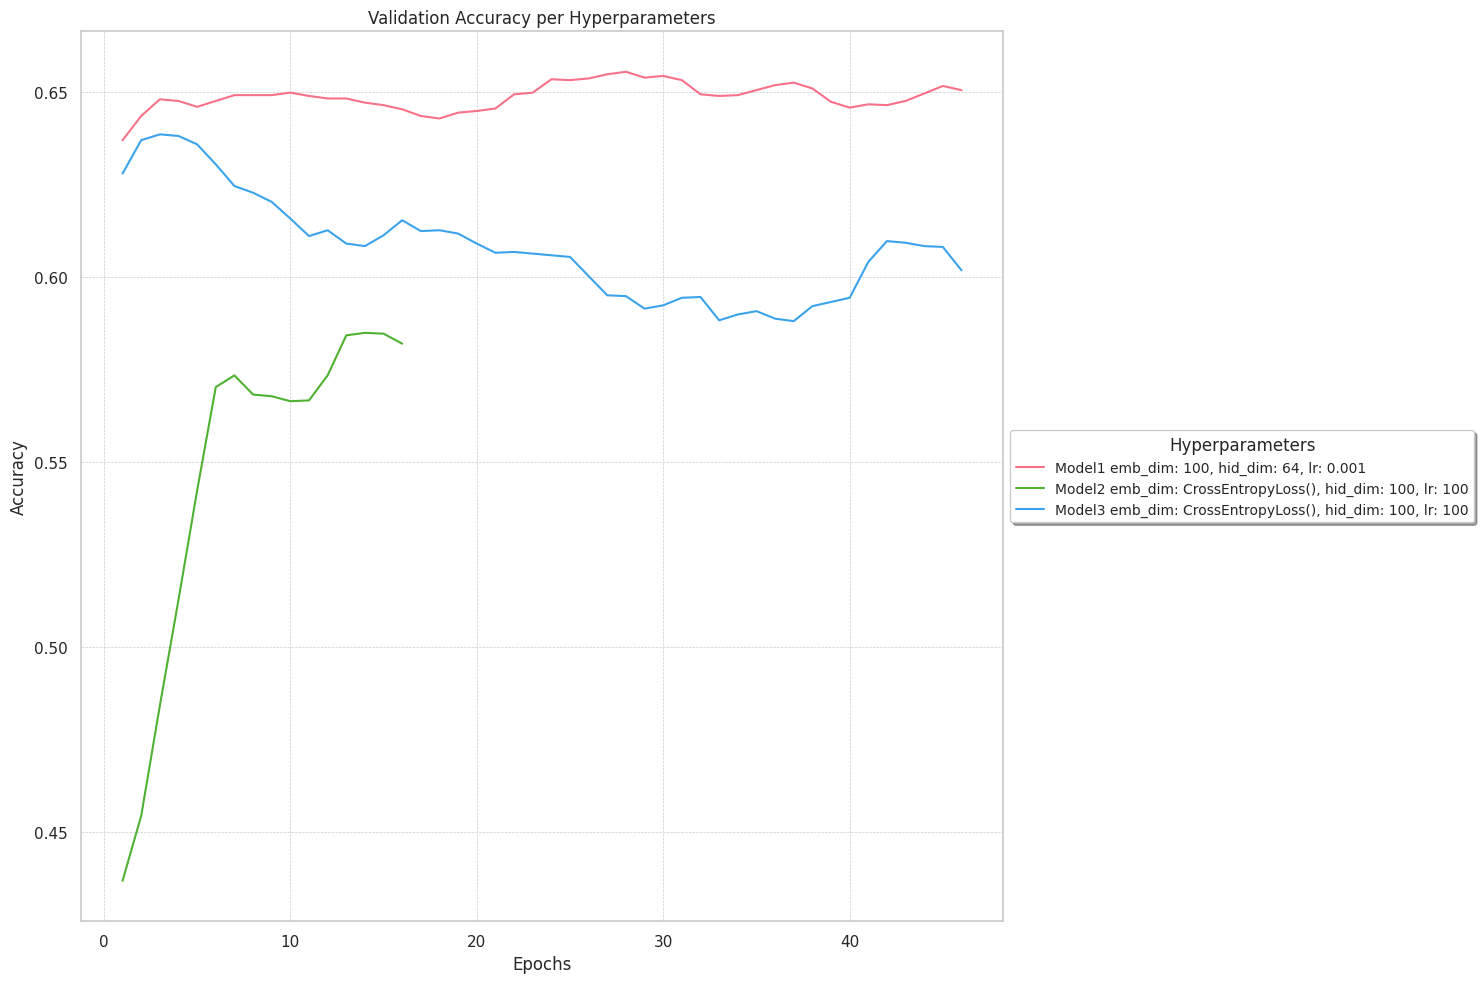

In [ ]:
def averages(data, window_size=5):
    """
    Compute the moving average of the given data using a specified window size.
    """
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Compute the smoothed accuracies
accurcttper_m1 = defaultdict(list)
accurcttper_m2 = defaultdict(list)
accurcttper_m3 = defaultdict(list)

# Compute the smoothed accuracies for each set of hyperparameters
for key, values in accuracy_perparams_m1.items():
    accurcttper_m1[key] = averages(values, window_size=5)

for key, values in accuracy_per_params_m2.items():
    accurcttper_m2[key] = averages(values, window_size=5)

for key, values in accuracy_per_params_m3.items():
    accurcttper_m3[key] = averages(values, window_size=5)

# Plot tuning results
plt.figure(figsize=(15, 10))
palette = sns.color_palette("husl", len(accurcttper_m1) + len(accurcttper_m2) + len(accurcttper_m3))

# Plot the accuracy for each set of hyperparameters
for i, (key, values) in enumerate(accurcttper_m1.items()):
    plt.plot(np.arange(1, len(values) + 1), values, label=f"Model1 emb_dim: {key[0][1]}, hid_dim: {key[1][1]}, lr: {key[2][1]}", color=palette[i])

for i, (key, values) in enumerate(accurcttper_m2.items(), start=len(accurcttper_m1)):
    plt.plot(np.arange(1, len(values) + 1), values, label=f"Model2 emb_dim: {key[0][1]}, hid_dim: {key[1][1]}, lr: {key[2][1]}", color=palette[i])

for i, (key, values) in enumerate(accurcttper_m3.items(), start=len(accurcttper_m1) + len(accurcttper_m2)):
    plt.plot(np.arange(1, len(values) + 1), values, label=f"Model3 emb_dim: {key[0][1]}, hid_dim: {key[1][1]}, lr: {key[2][1]}", color=palette[i])

# Add labels, title, grid, and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Hyperparameters')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, ncol=1, fontsize='small', title='Hyperparameters')
plt.tight_layout()
plt.show()